<div style="background-color: brown; padding: 10px;">

Course [IT790A] Explainable AI

Name: Abed Bakkour

Username: a22abeal
</div>

## Contents

- [Setup](#Setup-and-overview)

- [Data cleaning](#Data-cleaning)

    - [Categorical variables](#Categorical-variables)

    - [Numerical variables](#Numerical-variables)

- [Grid search and modeling](#Grid-search-and-modeling)

- [Train](#Train-with-best-parameters)

- [Predict](#Predict)

- [Explain model with SHAP](#Explain-model-with-SHAP)

    - [Global explanation](#Global-explanation-(overall))
    
        - [SHAP Summary Plot](#SHAP-Summary-Plot)
        - [SHAP Dependence Plot](#SHAP-Dependence-Plot)
        - [SHAP Interaction Value Plot](#SHAP-Interaction-Value-Plot)
    
    - [Local explanation](#Local-explanation-(one-day))

- [Questions and Answers](#Questions-and-answers)

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

import shap
import time
import warnings

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Setup and overview 

In [2]:
df = pd.read_csv('../data/day-bikesharing.csv',parse_dates=['dteday'],index_col=1) # Load the data

In [3]:
def add_features(df):
    df['year'] = df.index.year # yr exists already
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

2011.Jan.1 is a Saturday.

Note: 'dayofweek' 5 means a Saturday.

In [4]:
add_features(df)
df.head(3)

instant  season  yr  mnth  holiday  weekday  workingday  \
dteday                                                                
2011-01-01        1       1   0     1        0        6           0   
2011-01-02        2       1   0     1        0        0           0   
2011-01-03        3       1   0     1        0        1           1   

            weathersit      temp     atemp       hum  windspeed  casual  \
dteday                                                                    
2011-01-01           2  0.344167  0.363625  0.805833   0.160446     331   
2011-01-02           2  0.363478  0.353739  0.696087   0.248539     131   
2011-01-03           1  0.196364  0.189405  0.437273   0.248309     120   

            registered   cnt  year  month  day  dayofweek  
dteday                                                     
2011-01-01         654   985  2011      1    1          5  
2011-01-02         670   801  2011      1    2          6  
2011-01-03        1229  1349  2011      1    3          0

## Notice: We select meaningful variables for a better understanding of the SHAP results. 

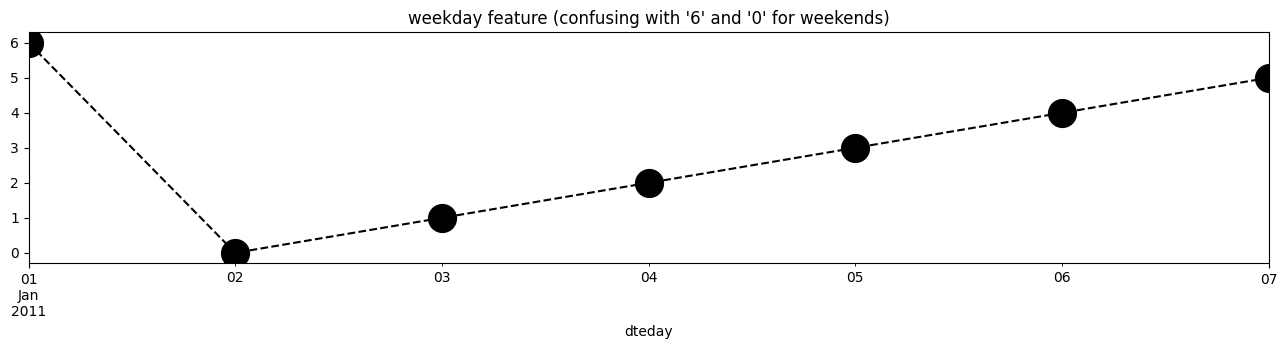

In [5]:
# Let's use 'dayofweek' instead of 'weekday'.
plt.figure(figsize=(16,3))
df['weekday'][:7].plot(linestyle='--', marker='o', color='k', ms=20, 
                       title='weekday feature (confusing with \'6\' and \'0\' for weekends)')
plt.show()

## We will use 'dayofweek' variable when describing each day of a week. Weekends of Saturday and Sunday are 5 and 6. The other weekdays are 0 to 4.

- When analyzing with SHAP, we consider higher numbers of 'dayofweek' feature to show the weekends.

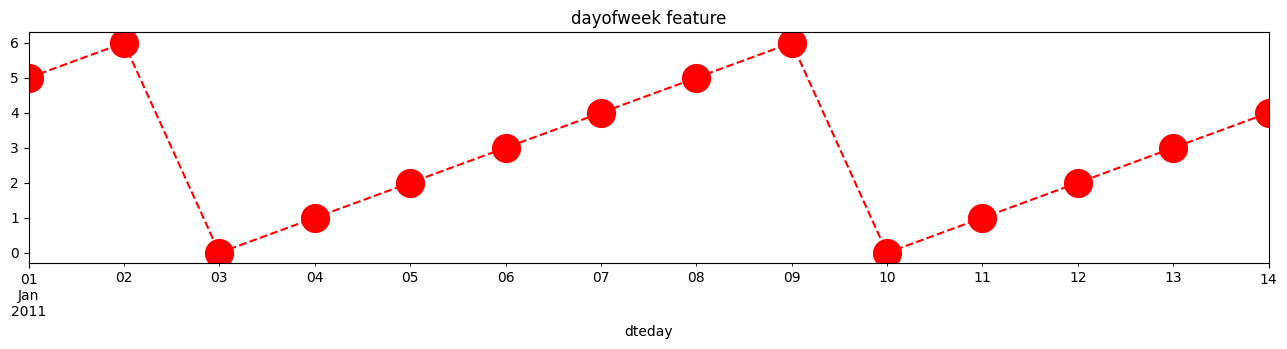

In [6]:
plt.figure(figsize=(16,3))
df['dayofweek'][:14].plot(linestyle='--', marker='o', color='r', ms=20, 
                       title='dayofweek feature')
plt.show()

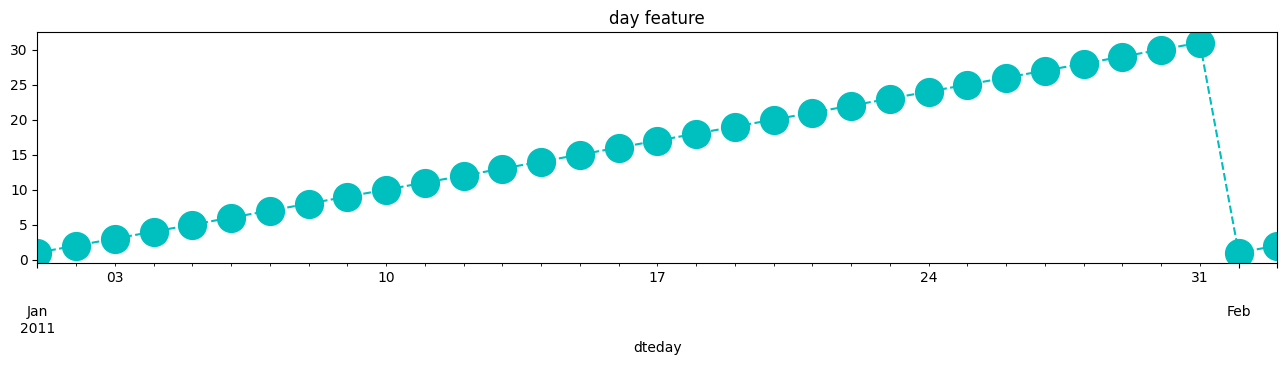

In [7]:
# Day feature shows whether it is a start of the month or the end of the month (1 to 30 or 31).
plt.figure(figsize=(16,3))
df['day'][:33].plot(linestyle='--', marker='o', color='c', ms=20, title='day feature')
plt.show()

## Workingday feature is a boolean. 

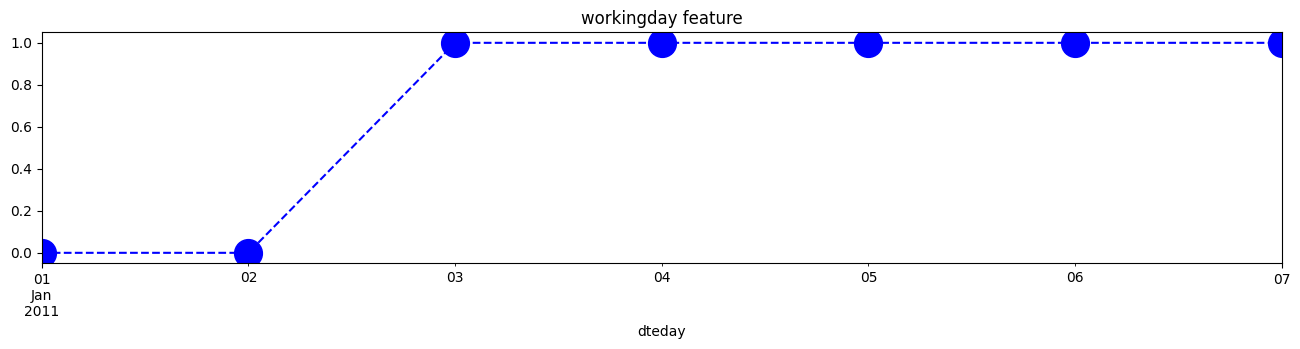

In [8]:
plt.figure(figsize=(16,3))
df['workingday'][:7].plot(linestyle='--', marker='o', color='b', ms=20, title='workingday feature')
plt.show()

## Note that season 1 indicates winter. Do you agree?

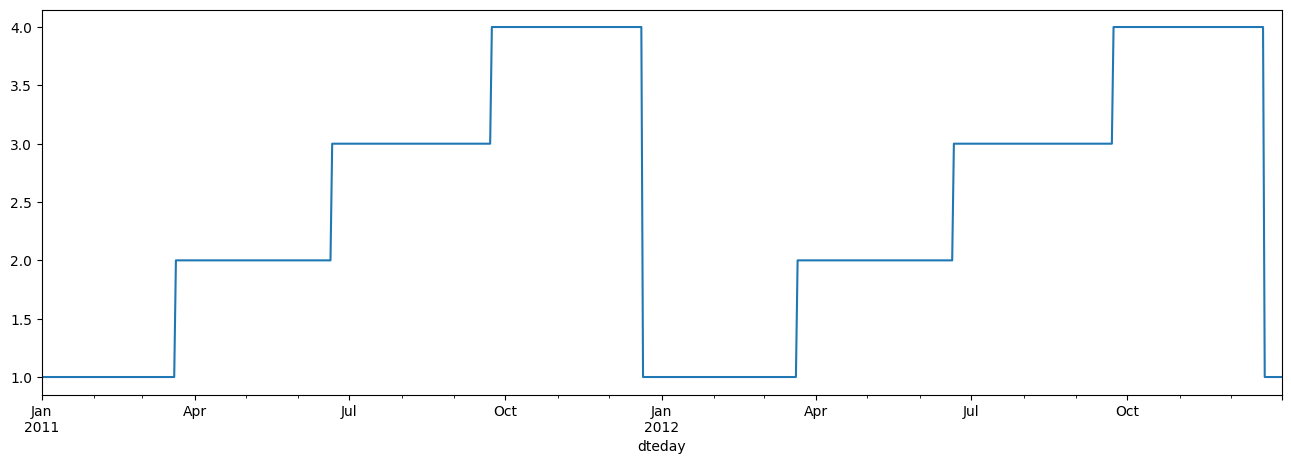

In [9]:
plt.figure(figsize=(16,5))
df['season'].plot()
plt.show()

In [10]:
df.season.value_counts()

3    188
2    184
1    181
4    178
Name: season, dtype: int64

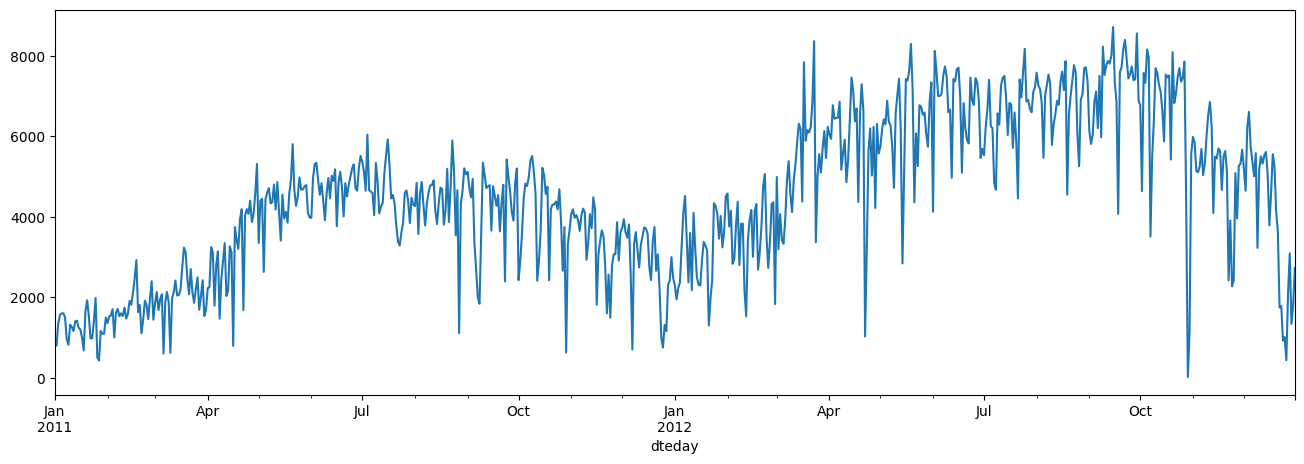

In [11]:
plt.figure(figsize=(16,5))
df['cnt'].plot()
plt.show()

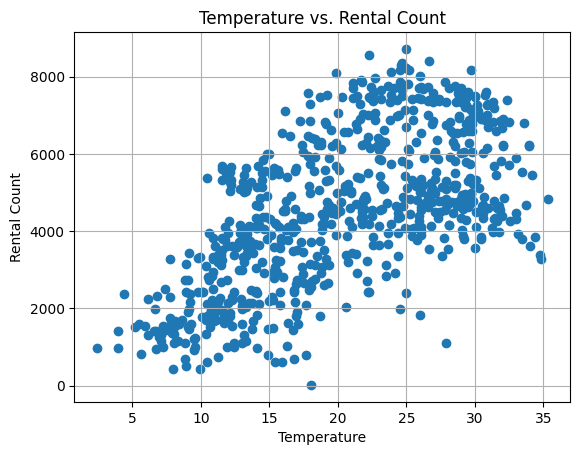

In [12]:
plt.scatter(x=df.temp*41,y=df["cnt"]) # denormalize temperature by multiplying 41
plt.grid(True)
plt.xlabel('Temperature')
plt.ylabel('Rental Count')
plt.title('Temperature vs. Rental Count')
plt.show()

Text(0.5, 1.0, 'Average Rental Count by Month')

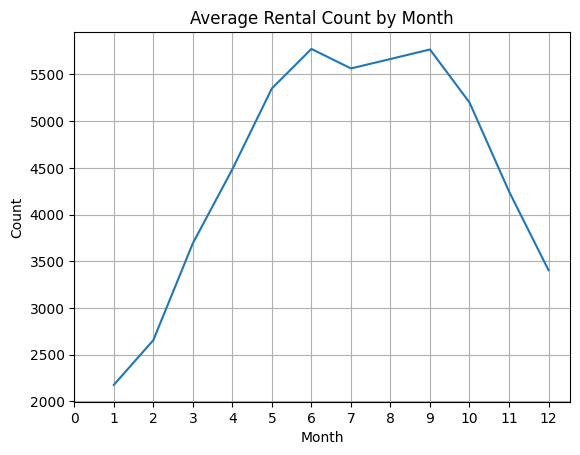

In [13]:
# from January to April, the demand is relatively low due to Winter 
#(there are not a lot of people that's brave enough to bike on icy road, are there?). 
# And the peak demand happends around Summer time (from May to October) and drop again.
group_month = df.groupby(['month'])
average_by_month = group_month['cnt'].mean()

plt.plot(average_by_month.index,average_by_month)
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(np.arange(13))
plt.grid(True)
plt.title('Average Rental Count by Month')

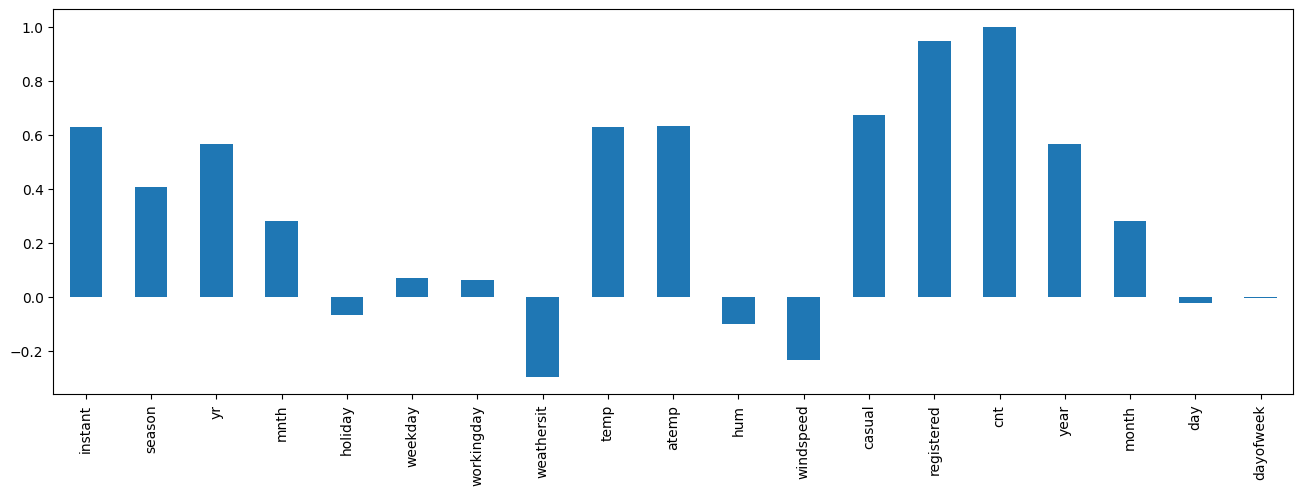

In [14]:
#correlation of total cnt with other variables
plt.figure(figsize=(16,5))
df.corr()['cnt'].plot(kind='bar')
plt.show()

In [15]:
#This is the normalized version.
# temp: The values are divided to 41 (max)
# atemp: The values are divided to 50 (max)
# hum: The values are divided to 100 (max)
# windspeed: The values are divided to 67 (max)
df.describe().T

count         mean          std          min          25%  \
instant     731.0   366.000000   211.165812     1.000000   183.500000   
season      731.0     2.496580     1.110807     1.000000     2.000000   
yr          731.0     0.500684     0.500342     0.000000     0.000000   
mnth        731.0     6.519836     3.451913     1.000000     4.000000   
holiday     731.0     0.028728     0.167155     0.000000     0.000000   
weekday     731.0     2.997264     2.004787     0.000000     1.000000   
workingday  731.0     0.683995     0.465233     0.000000     0.000000   
weathersit  731.0     1.395349     0.544894     1.000000     1.000000   
temp        731.0     0.495385     0.183051     0.059130     0.337083   
atemp       731.0     0.474354     0.162961     0.079070     0.337842   
hum         731.0     0.627894     0.142429     0.000000     0.520000   
windspeed   731.0     0.190486     0.077498     0.022392     0.134950   
casual      731.0   848.176471   686.622488     2.000000   315.500000   
registered  731.0  3656.172367  1560.256377    20.000000  2497.000000   
cnt         731.0  4504.348837  1937.211452    22.000000  3152.000000   
year        731.0  2011.500684     0.500342  2011.000000  2011.000000   
month       731.0     6.519836     3.451913     1.000000     4.000000   
day         731.0    15.738714     8.809949     1.000000     8.000000   
dayofweek   731.0     3.002736     2.004787     0.000000     1.000000   

                    50%          75%          max  
instant      366.000000   548.500000   731.000000  
season         3.000000     3.000000     4.000000  
yr             1.000000     1.000000     1.000000  
mnth           7.000000    10.000000    12.000000  
holiday        0.000000     0.000000     1.000000  
weekday        3.000000     5.000000     6.000000  
workingday     1.000000     1.000000     1.000000  
weathersit     1.000000     2.000000     3.000000  
temp           0.498333     0.655417     0.861667  
atemp          0.486733     0.608602     0.840896  
hum            0.626667     0.730209     0.972500  
windspeed      0.180975     0.233214     0.507463  
casual       713.000000  1096.000000  3410.000000  
registered  3662.000000  4776.500000  6946.000000  
cnt         4548.000000  5956.000000  8714.000000  
year        2012.000000  2012.000000  2012.000000  
month          7.000000    10.000000    12.000000  
day           16.000000    23.000000    31.000000  
dayofweek      3.000000     5.000000     6.000000

In [16]:
df.dtypes

instant         int64
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
year            int64
month           int64
day             int64
dayofweek       int64
dtype: object

# Data cleaning

# Categorical variables

Perform one hot encoding on categorical variables. Machine learning algorithms assume (and require) the data to be numeric, so the categorical data must be pre-processed as a numerical data.  Categorical variables turn into binary features that are 'one hot' encoded, so if a feature is represented by that column, it receives a 1, otherwise a 0.

- The 'season' feature has 1: winter, 2: spring, 3: summer, 4: fall. 
- The 'holiday' and 'workingday' features are boolean: 1 when it is a holiday. 1 when it is a working day.

In [17]:
# Define the categorical variables
cat_var = ['season', 'holiday', 'workingday', 'weathersit', 'year']

In [18]:
# OneHotEncoder
ohe = OneHotEncoder(categories = 'auto')

In [19]:
# Fit the categorical variables to the encoder
encodeddf = ohe.fit_transform(df[cat_var])

In [20]:
# Create a DataFrame with the encoded value information
cat_df = pd.DataFrame(data = encodeddf.toarray(), columns = ohe.get_feature_names_out(cat_var))
cat_df

season_1  season_2  season_3  season_4  holiday_0  holiday_1  \
0         1.0       0.0       0.0       0.0        1.0        0.0   
1         1.0       0.0       0.0       0.0        1.0        0.0   
2         1.0       0.0       0.0       0.0        1.0        0.0   
3         1.0       0.0       0.0       0.0        1.0        0.0   
4         1.0       0.0       0.0       0.0        1.0        0.0   
..        ...       ...       ...       ...        ...        ...   
726       1.0       0.0       0.0       0.0        1.0        0.0   
727       1.0       0.0       0.0       0.0        1.0        0.0   
728       1.0       0.0       0.0       0.0        1.0        0.0   
729       1.0       0.0       0.0       0.0        1.0        0.0   
730       1.0       0.0       0.0       0.0        1.0        0.0   

     workingday_0  workingday_1  weathersit_1  weathersit_2  weathersit_3  \
0             1.0           0.0           0.0           1.0           0.0   
1             1.0           0.0           0.0           1.0           0.0   
2             0.0           1.0           1.0           0.0           0.0   
3             0.0           1.0           1.0           0.0           0.0   
4             0.0           1.0           1.0           0.0           0.0   
..            ...           ...           ...           ...           ...   
726           0.0           1.0           0.0           1.0           0.0   
727           0.0           1.0           0.0           1.0           0.0   
728           1.0           0.0           0.0           1.0           0.0   
729           1.0           0.0           1.0           0.0           0.0   
730           0.0           1.0           0.0           1.0           0.0   

     year_2011  year_2012  
0          1.0        0.0  
1          1.0        0.0  
2          1.0        0.0  
3          1.0        0.0  
4          1.0        0.0  
..         ...        ...  
726        0.0        1.0  
727        0.0        1.0  
728        0.0        1.0  
729        0.0        1.0  
730        0.0        1.0  

[731 rows x 13 columns]

In [21]:
# rename the column names from 1,2,3,4 to spring, summer, fall, winter
cat_df.rename(columns={'season_1': 'winter', 'season_2': 'spring', 'season_3': 'summer', 'season_4': 'fall'}, inplace=True)
cat_df.rename(columns={'weathersit_1': 'clear', 'weathersit_2': 'cloudy', 'weathersit_3': 'lightsnow.rain'}, inplace=True)
cat_df

winter  spring  summer  fall  holiday_0  holiday_1  workingday_0  \
0       1.0     0.0     0.0   0.0        1.0        0.0           1.0   
1       1.0     0.0     0.0   0.0        1.0        0.0           1.0   
2       1.0     0.0     0.0   0.0        1.0        0.0           0.0   
3       1.0     0.0     0.0   0.0        1.0        0.0           0.0   
4       1.0     0.0     0.0   0.0        1.0        0.0           0.0   
..      ...     ...     ...   ...        ...        ...           ...   
726     1.0     0.0     0.0   0.0        1.0        0.0           0.0   
727     1.0     0.0     0.0   0.0        1.0        0.0           0.0   
728     1.0     0.0     0.0   0.0        1.0        0.0           1.0   
729     1.0     0.0     0.0   0.0        1.0        0.0           1.0   
730     1.0     0.0     0.0   0.0        1.0        0.0           0.0   

     workingday_1  clear  cloudy  lightsnow.rain  year_2011  year_2012  
0             0.0    0.0     1.0             0.0        1.0        0.0  
1             0.0    0.0     1.0             0.0        1.0        0.0  
2             1.0    1.0     0.0             0.0        1.0        0.0  
3             1.0    1.0     0.0             0.0        1.0        0.0  
4             1.0    1.0     0.0             0.0        1.0        0.0  
..            ...    ...     ...             ...        ...        ...  
726           1.0    0.0     1.0             0.0        0.0        1.0  
727           1.0    0.0     1.0             0.0        0.0        1.0  
728           0.0    0.0     1.0             0.0        0.0        1.0  
729           0.0    1.0     0.0             0.0        0.0        1.0  
730           1.0    0.0     1.0             0.0        0.0        1.0  

[731 rows x 13 columns]

# Numerical variables

Machine learning is sensitive to the relative scales of numerical variables. The range of all variables need to be normalized so that each feature contributes approximately proportionately to the calculation.

In [22]:
# Define the numerical variables
num_var = ['temp', 'atemp', 'hum', 'windspeed', 'month', 'day', 'dayofweek']       

Create standardized, normalized

In [23]:
# StandardScaler object
scaler = StandardScaler()

In [24]:
# Fit the data to the scaler
numscaled = scaler.fit_transform(df[num_var])

Keep the original for later view

In [25]:
# for inverse transformation
inversed = scaler.inverse_transform(numscaled)
print(inversed)

[[ 0.344167  0.363625  0.805833 ...  1.        1.        5.      ]
 [ 0.363478  0.353739  0.696087 ...  1.        2.        6.      ]
 [ 0.196364  0.189405  0.437273 ...  1.        3.        0.      ]
 ...
 [ 0.253333  0.2424    0.752917 ... 12.       29.        5.      ]
 [ 0.255833  0.2317    0.483333 ... 12.       30.        6.      ]
 [ 0.215833  0.223487  0.5775   ... 12.       31.        0.      ]]


In [26]:
# Create DataFrame with original data
inversed_df = pd.DataFrame(data = inversed, columns = num_var)
inversed_df

# Calculate based on UCI info to retrieve the actual temperature and weather information
#temp : Normalized temperature in Celsius. The values are divided to 41 (max)
#atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
#hum: Normalized humidity. The values are divided to 100 (max)
#windspeed: Normalized wind speed. The values are divided to 67 (max)
inversed_origin = pd.concat([inversed_df.iloc[:,0] * 41, #temperature
           inversed_df.iloc[:,1] * 50,                   #feeling temperature
           inversed_df.iloc[:,2] * 100,                  #humidity
           inversed_df.iloc[:,3] * 67],                  #wind speed
          axis=1)
inversed_origin

temp     atemp      hum  windspeed
0    14.110847  18.18125  80.5833  10.749882
1    14.902598  17.68695  69.6087  16.652113
2     8.050924   9.47025  43.7273  16.636703
3     8.200000  10.60610  59.0435  10.739832
4     9.305237  11.46350  43.6957  12.522300
..         ...       ...      ...        ...
726  10.420847  11.33210  65.2917  23.458911
727  10.386653  12.75230  59.0000  10.416557
728  10.386653  12.12000  75.2917   8.333661
729  10.489153  11.58500  48.3333  23.500518
730   8.849153  11.17435  57.7500  10.374682

[731 rows x 4 columns]

Text(0.5, 0, 'daily time (# rows)')

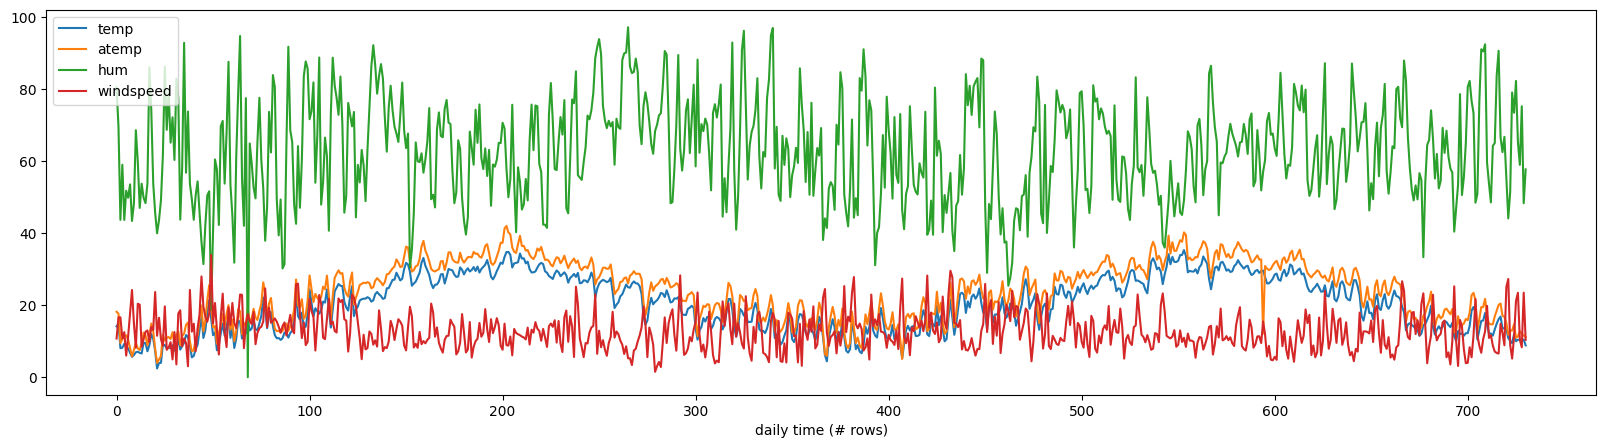

In [27]:
# timeseries of temp, atemp, humidity, windspeed
ax = inversed_origin.set_index(inversed_origin.index).plot(figsize=(20,5))
ax.set_xlabel('daily time (# rows)')

In [28]:
X_original = pd.concat([cat_df, inversed_origin, inversed_df[['month', 'day', 'dayofweek']]], axis=1)
X_original # Use this for SHAP plot view

winter  spring  summer  fall  holiday_0  holiday_1  workingday_0  \
0       1.0     0.0     0.0   0.0        1.0        0.0           1.0   
1       1.0     0.0     0.0   0.0        1.0        0.0           1.0   
2       1.0     0.0     0.0   0.0        1.0        0.0           0.0   
3       1.0     0.0     0.0   0.0        1.0        0.0           0.0   
4       1.0     0.0     0.0   0.0        1.0        0.0           0.0   
..      ...     ...     ...   ...        ...        ...           ...   
726     1.0     0.0     0.0   0.0        1.0        0.0           0.0   
727     1.0     0.0     0.0   0.0        1.0        0.0           0.0   
728     1.0     0.0     0.0   0.0        1.0        0.0           1.0   
729     1.0     0.0     0.0   0.0        1.0        0.0           1.0   
730     1.0     0.0     0.0   0.0        1.0        0.0           0.0   

     workingday_1  clear  cloudy  lightsnow.rain  year_2011  year_2012  \
0             0.0    0.0     1.0             0.0        1.0        0.0   
1             0.0    0.0     1.0             0.0        1.0        0.0   
2             1.0    1.0     0.0             0.0        1.0        0.0   
3             1.0    1.0     0.0             0.0        1.0        0.0   
4             1.0    1.0     0.0             0.0        1.0        0.0   
..            ...    ...     ...             ...        ...        ...   
726           1.0    0.0     1.0             0.0        0.0        1.0   
727           1.0    0.0     1.0             0.0        0.0        1.0   
728           0.0    0.0     1.0             0.0        0.0        1.0   
729           0.0    1.0     0.0             0.0        0.0        1.0   
730           1.0    0.0     1.0             0.0        0.0        1.0   

          temp     atemp      hum  windspeed  month   day  dayofweek  
0    14.110847  18.18125  80.5833  10.749882    1.0   1.0        5.0  
1    14.902598  17.68695  69.6087  16.652113    1.0   2.0        6.0  
2     8.050924   9.47025  43.7273  16.636703    1.0   3.0        0.0  
3     8.200000  10.60610  59.0435  10.739832    1.0   4.0        1.0  
4     9.305237  11.46350  43.6957  12.522300    1.0   5.0        2.0  
..         ...       ...      ...        ...    ...   ...        ...  
726  10.420847  11.33210  65.2917  23.458911   12.0  27.0        3.0  
727  10.386653  12.75230  59.0000  10.416557   12.0  28.0        4.0  
728  10.386653  12.12000  75.2917   8.333661   12.0  29.0        5.0  
729  10.489153  11.58500  48.3333  23.500518   12.0  30.0        6.0  
730   8.849153  11.17435  57.7500  10.374682   12.0  31.0        0.0  

[731 rows x 20 columns]

In [29]:
# Create DataFrame with numerically scaled data
num_df = pd.DataFrame(data = numscaled, columns = num_var)
num_df

temp     atemp       hum  windspeed     month       day  dayofweek
0   -0.826662 -0.679946  1.250171  -0.387892 -1.600161 -1.674108   0.996930
1   -0.721095 -0.740652  0.479113   0.749602 -1.600161 -1.560522   1.496077
2   -1.634657 -1.749767 -1.339274   0.746632 -1.600161 -1.446936  -1.498809
3   -1.614780 -1.610270 -0.263182  -0.389829 -1.600161 -1.333351  -0.999661
4   -1.467414 -1.504971 -1.341494  -0.046307 -1.600161 -1.219765  -0.500513
..        ...       ...       ...        ...       ...       ...        ...
726 -1.318665 -1.521108  0.175807   2.061426  1.588660  1.279122  -0.001366
727 -1.323224 -1.346690 -0.266238  -0.452131  1.588660  1.392707   0.497782
728 -1.323224 -1.424344  0.878392  -0.853552  1.588660  1.506293   0.996930
729 -1.309558 -1.490049 -1.015664   2.069444  1.588660  1.619879   1.496077
730 -1.528225 -1.540482 -0.354061  -0.460201  1.588660  1.733465  -1.498809

[731 rows x 7 columns]

Define X (input): Concatenate one hot encoded categorical + normalized numerical data

In [30]:
Xdf = pd.concat([cat_df, num_df], axis = 1)
print(Xdf.shape)
Xdf.head(5)

(731, 20)


winter  spring  summer  fall  holiday_0  holiday_1  workingday_0  \
0     1.0     0.0     0.0   0.0        1.0        0.0           1.0   
1     1.0     0.0     0.0   0.0        1.0        0.0           1.0   
2     1.0     0.0     0.0   0.0        1.0        0.0           0.0   
3     1.0     0.0     0.0   0.0        1.0        0.0           0.0   
4     1.0     0.0     0.0   0.0        1.0        0.0           0.0   

   workingday_1  clear  cloudy  lightsnow.rain  year_2011  year_2012  \
0           0.0    0.0     1.0             0.0        1.0        0.0   
1           0.0    0.0     1.0             0.0        1.0        0.0   
2           1.0    1.0     0.0             0.0        1.0        0.0   
3           1.0    1.0     0.0             0.0        1.0        0.0   
4           1.0    1.0     0.0             0.0        1.0        0.0   

       temp     atemp       hum  windspeed     month       day  dayofweek  
0 -0.826662 -0.679946  1.250171  -0.387892 -1.600161 -1.674108   0.996930  
1 -0.721095 -0.740652  0.479113   0.749602 -1.600161 -1.560522   1.496077  
2 -1.634657 -1.749767 -1.339274   0.746632 -1.600161 -1.446936  -1.498809  
3 -1.614780 -1.610270 -0.263182  -0.389829 -1.600161 -1.333351  -0.999661  
4 -1.467414 -1.504971 -1.341494  -0.046307 -1.600161 -1.219765  -0.500513

In [31]:
# Save column names for SHAP usage
NAMES = Xdf.columns
NAMES

Index(['winter', 'spring', 'summer', 'fall', 'holiday_0', 'holiday_1',
       'workingday_0', 'workingday_1', 'clear', 'cloudy', 'lightsnow.rain',
       'year_2011', 'year_2012', 'temp', 'atemp', 'hum', 'windspeed', 'month',
       'day', 'dayofweek'],
      dtype='object')

<AxesSubplot: >

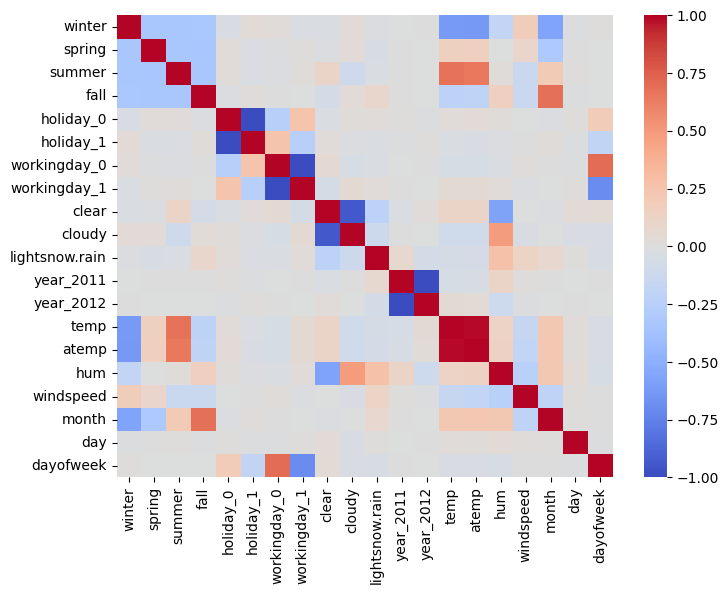

In [32]:
plt.subplots(figsize=(8, 6))
sb.heatmap(Xdf.corr(), cmap='coolwarm')

In [33]:
# Check if there is any non available
Xdf.isna().any().sum()

0

Define Y (to predict): Extract target

In [34]:
# Here, indicate which target to predict (cnt or casual or registered) 
# For the different models for each customer in the assignment, change the target 
to_predict = 'cnt'

In [35]:
# Here, indicate which target to predict (cnt or casual or registered) 
y = df[to_predict]

# Normalize target data: Calculate mean and standard deviation
y_mu = y.mean(0)
y_sd = y.std(0)

print('y mean:', y_mu, ' y std:' , y_sd)

y_norm = (y - y_mu) / y_sd
y_norm = y_norm.values.ravel() #dataframe to 1D array
#y_norm

y mean: 4504.3488372093025  y std: 1937.2114516187676


In [36]:
len(y)

731

In [37]:
# to verify, leave a whole dataframe with x and y together
tdf = pd.concat([Xdf, pd.DataFrame(y.values)], axis = 1)
tdf.rename(columns={0:'cnt'}, inplace=True) #change the column name
tdf

winter  spring  summer  fall  holiday_0  holiday_1  workingday_0  \
0       1.0     0.0     0.0   0.0        1.0        0.0           1.0   
1       1.0     0.0     0.0   0.0        1.0        0.0           1.0   
2       1.0     0.0     0.0   0.0        1.0        0.0           0.0   
3       1.0     0.0     0.0   0.0        1.0        0.0           0.0   
4       1.0     0.0     0.0   0.0        1.0        0.0           0.0   
..      ...     ...     ...   ...        ...        ...           ...   
726     1.0     0.0     0.0   0.0        1.0        0.0           0.0   
727     1.0     0.0     0.0   0.0        1.0        0.0           0.0   
728     1.0     0.0     0.0   0.0        1.0        0.0           1.0   
729     1.0     0.0     0.0   0.0        1.0        0.0           1.0   
730     1.0     0.0     0.0   0.0        1.0        0.0           0.0   

     workingday_1  clear  cloudy  ...  year_2011  year_2012      temp  \
0             0.0    0.0     1.0  ...        1.0        0.0 -0.826662   
1             0.0    0.0     1.0  ...        1.0        0.0 -0.721095   
2             1.0    1.0     0.0  ...        1.0        0.0 -1.634657   
3             1.0    1.0     0.0  ...        1.0        0.0 -1.614780   
4             1.0    1.0     0.0  ...        1.0        0.0 -1.467414   
..            ...    ...     ...  ...        ...        ...       ...   
726           1.0    0.0     1.0  ...        0.0        1.0 -1.318665   
727           1.0    0.0     1.0  ...        0.0        1.0 -1.323224   
728           0.0    0.0     1.0  ...        0.0        1.0 -1.323224   
729           0.0    1.0     0.0  ...        0.0        1.0 -1.309558   
730           1.0    0.0     1.0  ...        0.0        1.0 -1.528225   

        atemp       hum  windspeed     month       day  dayofweek   cnt  
0   -0.679946  1.250171  -0.387892 -1.600161 -1.674108   0.996930   985  
1   -0.740652  0.479113   0.749602 -1.600161 -1.560522   1.496077   801  
2   -1.749767 -1.339274   0.746632 -1.600161 -1.446936  -1.498809  1349  
3   -1.610270 -0.263182  -0.389829 -1.600161 -1.333351  -0.999661  1562  
4   -1.504971 -1.341494  -0.046307 -1.600161 -1.219765  -0.500513  1600  
..        ...       ...        ...       ...       ...        ...   ...  
726 -1.521108  0.175807   2.061426  1.588660  1.279122  -0.001366  2114  
727 -1.346690 -0.266238  -0.452131  1.588660  1.392707   0.497782  3095  
728 -1.424344  0.878392  -0.853552  1.588660  1.506293   0.996930  1341  
729 -1.490049 -1.015664   2.069444  1.588660  1.619879   1.496077  1796  
730 -1.540482 -0.354061  -0.460201  1.588660  1.733465  -1.498809  2729  

[731 rows x 21 columns]

Split training and test data

In [38]:
# Split the data into training, validation, and test data:
X_train, X_test, y_train, y_test = train_test_split(Xdf, y_norm, test_size = 0.2, random_state=1)
# Validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) 

# Grid search and modeling

In [39]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [40]:
# Build the model with 
# XGBoost Training Parameter Reference: 
#   https://github.com/dmlc/xgboost
#   https://xgboost.readthedocs.io/en/latest/parameter.html

# XGBRegressor object and GridSearch object
xgbmodel = xgb.XGBRegressor() 
clf = GridSearchCV(estimator = xgbmodel,
                   param_grid = params,
                   cv = 3,
                   verbose=1)

In [41]:
# Fit the training data to the GridSearch object
t0 = time.time()
clf.fit(X_train, y_train)
t1 = time.time()
print(t1-t0, " sec taken")

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
71.54616165161133  sec taken


In [42]:
# Display the best parameters from the GridSearch
# Let's assume that this is a good enough model to use for SHAP
print(clf.best_params_)
print(clf.best_score_)

{'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8}
0.8633448414950647


# Train with best parameters

In [43]:
from sklearn._config import get_config, set_config
set_config(print_changed_only=False)

In [44]:
xgbmodel = xgb.XGBRegressor(**clf.best_params_, random_state=0)

In [45]:
# Fit the training data to the model
xgbmodel.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)])

[0]	validation_0-rmse:0.84811	validation_1-rmse:0.86342
[1]	validation_0-rmse:0.67246	validation_1-rmse:0.69370
[2]	validation_0-rmse:0.54534	validation_1-rmse:0.58267
[3]	validation_0-rmse:0.45971	validation_1-rmse:0.50922
[4]	validation_0-rmse:0.40182	validation_1-rmse:0.45342
[5]	validation_0-rmse:0.36729	validation_1-rmse:0.40947
[6]	validation_0-rmse:0.33601	validation_1-rmse:0.38506
[7]	validation_0-rmse:0.31756	validation_1-rmse:0.37200
[8]	validation_0-rmse:0.30014	validation_1-rmse:0.36170
[9]	validation_0-rmse:0.28967	validation_1-rmse:0.35561
[10]	validation_0-rmse:0.28115	validation_1-rmse:0.34970
[11]	validation_0-rmse:0.27210	validation_1-rmse:0.34349
[12]	validation_0-rmse:0.27027	validation_1-rmse:0.33654
[13]	validation_0-rmse:0.26416	validation_1-rmse:0.33288
[14]	validation_0-rmse:0.25919	validation_1-rmse:0.33080
[15]	validation_0-rmse:0.25919	validation_1-rmse:0.33081
[16]	validation_0-rmse:0.25706	validation_1-rmse:0.32948
[17]	validation_0-rmse:0.25709	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', predictor=None, ...)

# Predict

In [46]:
eval_result = xgbmodel.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse'])) #training
print(training_rounds)

range(0, 100)


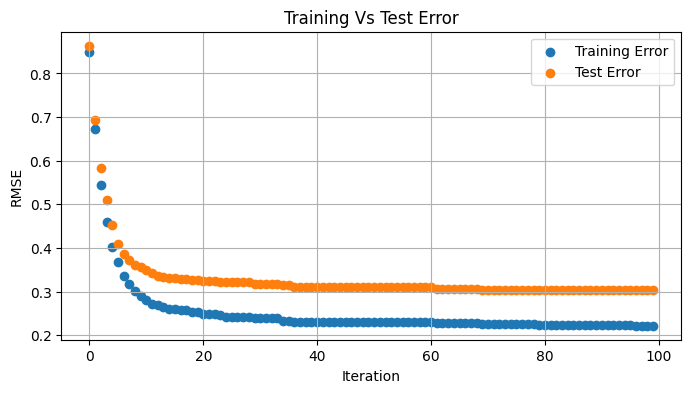

In [47]:
plt.figure(figsize=(8,4))
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Test Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Test Error')
plt.legend()
plt.show()

In [48]:
ypredicted = xgbmodel.predict(X_test) 

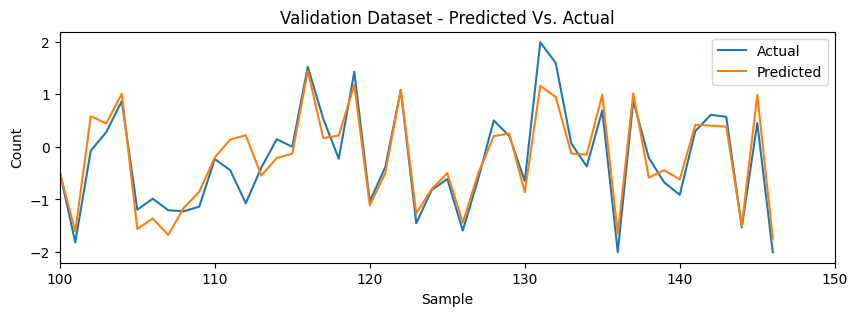

In [49]:
plt.figure(figsize=(10,3))
# Actual Vs Predicted
plt.plot(y_test, label='Actual')
plt.plot(ypredicted, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Count')
plt.xlim([100,150])
plt.title('Validation Dataset - Predicted Vs. Actual')
plt.legend()
plt.show()

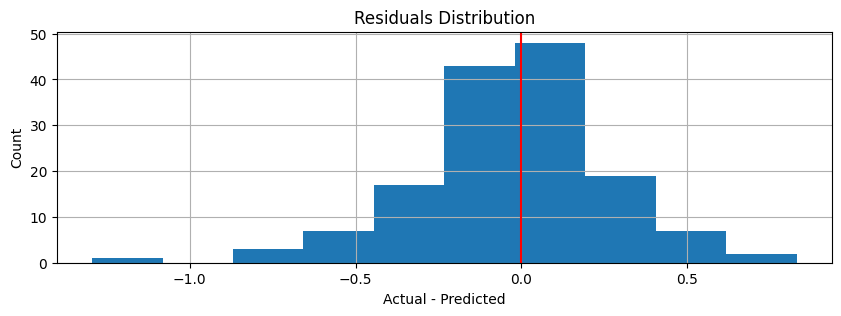

In [50]:
# Over prediction and Under Prediction needs to be balanced
# Training Data Residuals
residuals = (y_test - ypredicted) # * y_sd + y_mu (for actual cnt numbers)

plt.figure(figsize=(10,3))
plt.hist(residuals)
plt.grid(True)
plt.xlabel('Actual - Predicted')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='r')
plt.show()

In [51]:
print("RMSE: {0:0.4f}".format(mean_squared_error(y_test, ypredicted)))

RMSE: 0.0884


In [52]:
# Show the influencing features in order (with feature_importances_)
# Indicate which parameter used to decide the ranking of important features
important_features = pd.Series(data=xgbmodel.feature_importances_, index=NAMES)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)

# There are different parameters:
# Refer to, https://github.com/dmlc/xgboost/blob/master/python-package/xgboost/core.py
#        * 'weight': the number of times a feature is used to split the data across all trees.
#        * 'gain': the average gain across all splits the feature is used in.
#        * 'cover': the average coverage across all splits the feature is used in.
#        * 'total_gain': the total gain across all splits the feature is used in.
#        * 'total_cover': the total coverage across all splits the feature is used in.

year_2012         0.334441
month             0.148238
year_2011         0.093973
atemp             0.091646
winter            0.060549
fall              0.057606
clear             0.034687
cloudy            0.033488
temp              0.031691
lightsnow.rain    0.028922
hum               0.022926
windspeed         0.017095
workingday_0      0.010901
holiday_0         0.009047
day               0.007691
dayofweek         0.007369
workingday_1      0.007166
spring            0.002563
holiday_1         0.000000
summer            0.000000
dtype: float32


In [53]:
important_features = pd.Series(data=xgbmodel.get_booster().get_score(importance_type='gain'), index=NAMES)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)

year_2012         24.965616
month             11.065815
year_2011          7.015013
atemp              6.841238
winter             4.519948
fall               4.300218
clear              2.589336
cloudy             2.499859
temp               2.365730
lightsnow.rain     2.159016
hum                1.711424
windspeed          1.276122
workingday_0       0.813745
holiday_0          0.675331
day                0.574106
dayofweek          0.550102
workingday_1       0.534939
spring             0.191319
summer                  NaN
holiday_1               NaN
dtype: float64


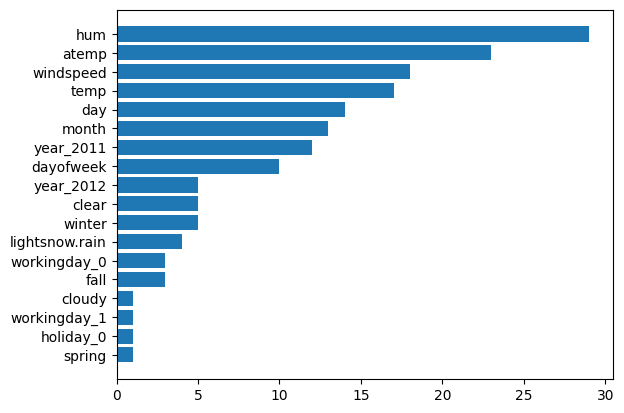

In [54]:
# Show the influencing features in order (with get_booster().get_fscore())
# fscore is based on the number of times a feature is used in a tree
fscore = xgbmodel.get_booster().get_fscore().items()
lists = sorted(fscore, key=lambda x:x[1]) # sorted by value, return a list of tuples
fkey, fvalue = zip(*lists) # unpack a list of pairs into two tuples

plt.barh(fkey, fvalue)
plt.show()

# Check which single instances to compare with LIME

To find a single day to examine, search for conditions and pick a specific index to investigate

In [55]:
# weekend and winter
sampled_at_hu = X_test[(X_test['workingday_0']==1) & (X_test['winter']==1)][:5]
sampled_at_hu

winter  spring  summer  fall  holiday_0  holiday_1  workingday_0  \
8       1.0     0.0     0.0   0.0        1.0        0.0           1.0   
364     1.0     0.0     0.0   0.0        1.0        0.0           1.0   
414     1.0     0.0     0.0   0.0        1.0        0.0           1.0   
434     1.0     0.0     0.0   0.0        1.0        0.0           1.0   
421     1.0     0.0     0.0   0.0        1.0        0.0           1.0   

     workingday_1  clear  cloudy  lightsnow.rain  year_2011  year_2012  \
8             0.0    1.0     0.0             0.0        1.0        0.0   
364           0.0    1.0     0.0             0.0        1.0        0.0   
414           0.0    0.0     1.0             0.0        0.0        1.0   
434           0.0    1.0     0.0             0.0        0.0        1.0   
421           0.0    1.0     0.0             0.0        0.0        1.0   

         temp     atemp       hum  windspeed     month       day  dayofweek  
8   -1.951895 -2.199446 -1.361096   2.214012 -1.600161 -0.765422   1.496077  
364 -0.466773 -0.369869 -0.084739   0.383083  1.588660  1.733465   0.996930  
414 -1.177444 -1.280727 -0.787324   0.808650 -1.310268  0.370436   1.496077  
434 -1.136444 -1.207168 -1.949511   0.455341 -1.020375 -0.651836   0.996930  
421 -1.181998 -1.265253 -1.530890   0.190365 -1.310268  1.165536   1.496077

In [56]:
PICK = 364
Xdf[Xdf.index==PICK]

winter  spring  summer  fall  holiday_0  holiday_1  workingday_0  \
364     1.0     0.0     0.0   0.0        1.0        0.0           1.0   

     workingday_1  clear  cloudy  lightsnow.rain  year_2011  year_2012  \
364           0.0    1.0     0.0             0.0        1.0        0.0   

         temp     atemp       hum  windspeed    month       day  dayofweek  
364 -0.466773 -0.369869 -0.084739   0.383083  1.58866  1.733465    0.99693

In [57]:
# review the target values, y[364] and tdf[tdf.index == 364]['cnt'].values[0] show target cnt = 2485
print(tdf[tdf.index == PICK]['cnt'].values[0])

2485


In [58]:
Xdf.iloc[[PICK]]

winter  spring  summer  fall  holiday_0  holiday_1  workingday_0  \
364     1.0     0.0     0.0   0.0        1.0        0.0           1.0   

     workingday_1  clear  cloudy  lightsnow.rain  year_2011  year_2012  \
364           0.0    1.0     0.0             0.0        1.0        0.0   

         temp     atemp       hum  windspeed    month       day  dayofweek  
364 -0.466773 -0.369869 -0.084739   0.383083  1.58866  1.733465    0.99693

Keep one day for local explanation later.

Find the appropriate single day to explain. Here, we focus on days in indices 364 and 180.

In [59]:
# Select one day for investigation with a force plot later
weekEnd_sample = Xdf.loc[[364]] #weekend-winter-364      #working day-winter-40
weekDay_sample = Xdf.loc[[180]] #working day-summer-180  #weekend-summer-247    

weekEnd_sample_origin = X_original.loc[[364]]
weekDay_sample_origin = X_original.loc[[180]]
weekEnd_sample_origin #weekDay_sample_origin

winter  spring  summer  fall  holiday_0  holiday_1  workingday_0  \
364     1.0     0.0     0.0   0.0        1.0        0.0           1.0   

     workingday_1  clear  cloudy  lightsnow.rain  year_2011  year_2012   temp  \
364           0.0    1.0     0.0             0.0        1.0        0.0  16.81   

        atemp      hum  windspeed  month   day  dayofweek  
364  20.70605  61.5833  14.750318   12.0  31.0        5.0

# Explain model with SHAP

In [60]:
X_original.head(5)

winter  spring  summer  fall  holiday_0  holiday_1  workingday_0  \
0     1.0     0.0     0.0   0.0        1.0        0.0           1.0   
1     1.0     0.0     0.0   0.0        1.0        0.0           1.0   
2     1.0     0.0     0.0   0.0        1.0        0.0           0.0   
3     1.0     0.0     0.0   0.0        1.0        0.0           0.0   
4     1.0     0.0     0.0   0.0        1.0        0.0           0.0   

   workingday_1  clear  cloudy  lightsnow.rain  year_2011  year_2012  \
0           0.0    0.0     1.0             0.0        1.0        0.0   
1           0.0    0.0     1.0             0.0        1.0        0.0   
2           1.0    1.0     0.0             0.0        1.0        0.0   
3           1.0    1.0     0.0             0.0        1.0        0.0   
4           1.0    1.0     0.0             0.0        1.0        0.0   

        temp     atemp      hum  windspeed  month  day  dayofweek  
0  14.110847  18.18125  80.5833  10.749882    1.0  1.0        5.0  
1  14.902598  17.68695  69.6087  16.652113    1.0  2.0        6.0  
2   8.050924   9.47025  43.7273  16.636703    1.0  3.0        0.0  
3   8.200000  10.60610  59.0435  10.739832    1.0  4.0        1.0  
4   9.305237  11.46350  43.6957  12.522300    1.0  5.0        2.0

In [61]:
# activate javascript, load javascript library when visualization is not showing
shap.initjs()

# explain all the predictions in the test set
t0 = time.time()
explainer = shap.TreeExplainer(xgbmodel)
shap_values = explainer.shap_values(Xdf)
t1 = time.time()
print(t1-t0, " sec taken")

0.0860445499420166  sec taken


- Note: xgbmodel contains training data set that it was built upon.

- TreeExplainer uses this model to compute conditional expectations. 

- Pass to explainer.shap_values the data samples to explain: it is often a test set, but in this case we use the full set.

# Questions and Answers

**<span style="color:brown">In our journey to predict bike sharing demand, we embarked on a series of data-driven steps. We began by meticulously preparing the dataset, engineering features like date components, temperature, and weather conditions. Categorical variables were transformed, and numerical features standardized for consistency. With the groundwork laid, we turned to model selection and chose the robust XGBoostRegressor, known for its prowess in regression tasks. Hyperparameter tuning further optimized the model's predictive power, and we embarked on training, closely monitoring performance with an evaluation set. The fruits of our labor were revealed as we evaluated the model, achieving an impressive RMSE of 0.0884, a testament to its accuracy. We delved deeper into feature importance, unearthing insights into the factors influencing bike rental counts. To complete our journey, SHAP values illuminated individual predictions, unraveling the intricate web of feature contributions. With these insights, we stand ready to unlock the secrets of bike sharing demand.</span>**

A-1. Based on the model and explanation results, explain how different seasons and three weather inputs (e.g., temperature, humidity, and windspeed) would affect the bike rental counts positively and/or negatively (if none, state that there would be no influence)?

If you are the CEO of this bike rental company, what is your marketing strategy for selected seasons or weather?

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


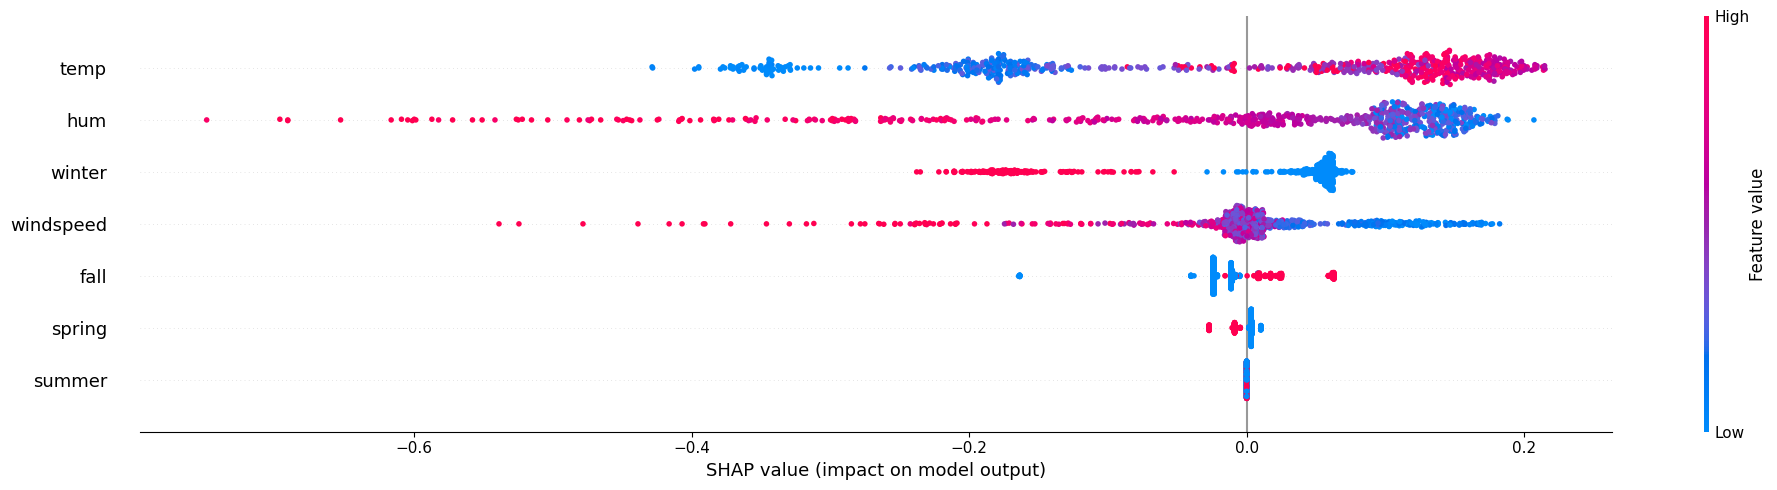

In [142]:
selected_features = ["winter", "spring", "summer", "fall", "temp", "hum", "windspeed"]

# Find the indices of the selected features in the original DataFrame
feature_indices = [Xdf.columns.get_loc(feature) for feature in selected_features]

# Sort the SHAP values and DataFrame based on the feature indices
selected_shap_values = shap_values[:, feature_indices]
selected_Xdf = Xdf[selected_features]

# Create a SHAP summary plot for the selected features
shap.summary_plot(selected_shap_values, selected_Xdf, show=False, axis_color="black", plot_size=(20,5))

The SHAP summary plot is a graphical tool that shows how different features (such as seasons and weather inputs) influence the prediction of a machine learning model (such as bike rental counts). The plot has two axes: the horizontal axis shows the SHAP value, which measures the impact of a feature on the model output, and the vertical axis shows the feature value, which indicates the actual value of a feature for each data point. The data points are colored according to the feature value, with purple representing high values and blue representing low values. The plot also has horizontal lines for each feature, which show how the feature values are distributed along the SHAP value axis. The more spread out the data points are along a line, the more variable the impact of that feature is on the model output. The closer the data points are to the center of the plot, the less impact that feature has on the model output.

Based on the SHAP summary plot and explanation results, here is how different seasons and three weather inputs would affect the bike rental counts:

- **Weather Inputs:**
    - The **temp** feature shows that when the temperature is low, it has a negative impact on the bike rental counts, meaning fewer people rent bikes. When the temperature is high, it has a positive impact on the bike rental counts, meaning more people rent bikes.
    - The **hum** feature shows that when the humidity is low, it has a positive impact on the bike rental counts, meaning more people rent bikes. When the humidity is high, it has a negative impact on the bike rental counts, meaning fewer people rent bikes.
    - The **windspeed** feature shows that when the windspeed is low, it has a positive impact on the bike rental counts, meaning more people rent bikes. When the windspeed is high, it has a negative impact on the bike rental counts, meaning fewer people rent bikes.
- **Seasons:**
    - When it is **winter**, it has a negative impact on the bike rental counts, meaning fewer people rent bikes. When it is **fall**, it has a positive impact on the bike rental counts, meaning more people rent bikes. However, fall season doesn't have a high SHAP value meaning we can't rely on the SHAP value and say that fall season really has a positive impact. The other season features such as **spring** and **summer** have extremely low SHAP values, which means they have very little impact on the model output. This also means that we cannot confidently describe how they affect the bike rental counts, as the effect might be negligible or influenced by other factors. Therefore, it might be better to focus on the weather inputs and the winter and fall seasons that have higher SHAP values as they have more clear and consistent effects on the bike rental counts.

Therefore, based on the model and explanation results, we can conclude that:

- The best weather conditions for bike rental are high temperature, low humidity, and low windspeed, as they have the most positive impact on the model output.
- The best season for bike rental is fall, as it has the most positive impact on the model output, while the worst season is winter, as it has the most negative impact on the model output. The other seasons have negligible or mixed effects that might depend on other factors.

If I were the CEO of this bike rental company, I would use the following marketing strategy for selected seasons or weather:

- **Seasonal Promotion Strategy:**
   - **Focus on Fall:** Promote fall as the ideal season for bike rentals. Offer special discounts, extended rental hours, or package deals that encourage customers to explore and enjoy the picturesque landscapes during this season. Highlight the comfortable weather and vibrant foliage.
   - **Winter Membership**: Introduce a winter membership program that offers significant discounts and incentives for renting bikes during the colder months. Provide members with benefits such as reduced hourly rates, extended rental durations, and priority access to winter bike models.
   - **Special Winter Packages**: Create all-inclusive winter biking packages that bundle bike rentals with hot beverages, cozy winter gear, and guided winter biking tours. Promote these packages as a unique way to experience the beauty of the winter season.

* **Weather-Responsive Pricing:**
   - **Dynamic Pricing:** Implement dynamic pricing based on weather conditions. When weather forecasts indicate favorable biking weather (e.g., higher temperatures, low humidity, low windspeed), offer discounted rental rates to attract spontaneous riders. Conversely, during adverse weather, maintain standard pricing.

- **Weather-Condition Alerts:**
   - **Weather Notifications:** Develop a weather notification system within mobile app or website. Send real-time alerts to users when the weather becomes suitable for biking. Encourage them to rent bikes and enjoy the outdoors. Conversely, during inclement weather, provide alternative suggestions for activities or services our company offers.

* **Seasonal Bike Fleet Management:**
   - **Optimize Bike Allocation:** Adjust bike fleet allocation based on seasonal demand. During peak seasons like fall, allocate a higher percentage of bikes to popular rental locations. In the off-season, redistribute bikes to storage or maintenance facilities to reduce costs.

***
***
***

A-2. Based on the model and explanation results, which type of days (“working days” and the “holiday/weekends”) would influence the bike rental counts positively and/or negatively (if none, state that there would be no influence)?  

If you are the CEO of this bike rental company, what is your marketing strategy for the working days and holiday/weekends (select the type of day and how to improve)?

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


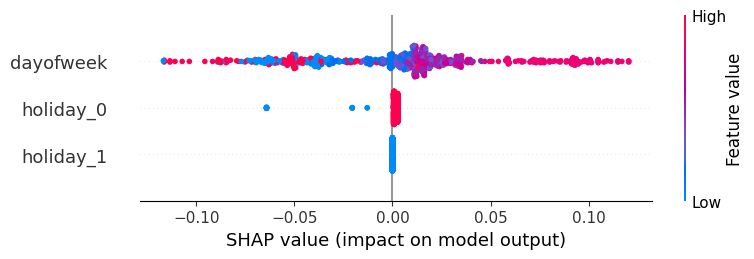

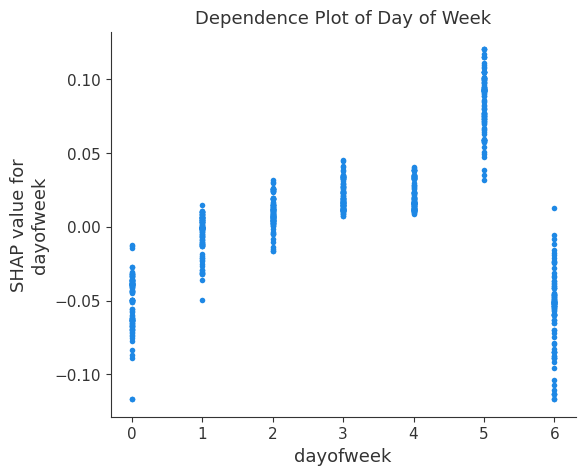

In [74]:
selected_features = ["holiday_0", "holiday_1", "dayofweek"]

# Find the indices of the selected features in the original DataFrame
feature_indices = [Xdf.columns.get_loc(feature) for feature in selected_features]

# Sort the SHAP values and DataFrame based on the feature indices
selected_shap_values = shap_values[:, feature_indices]
selected_Xdf = Xdf[selected_features]

# Create a SHAP summary plot for the selected features
shap.summary_plot(selected_shap_values, selected_Xdf)

# Create a Dependence plot for the "dayofweek" feature
shap.dependence_plot("dayofweek", shap_values, X_original, feature_names=NAMES, show=False, interaction_index = None, title= "Dependence Plot of Day of Week")

To assess the influence of working days, weekends, and holidays on bike rental counts, we created two informative plots: a summary plot and a dependence plot. These visualizations shed light on the impact of these features, particularly the "dayofweek," "holiday_0," and "holiday_1" features. Noting that the value 0 means that the day is not a holiday, while the value 1 means that the day is a holiday.

**Summary Plot:**
The first plot, known as the SHAP summary plot, provides an overview of how these three features ("dayofweek," "holiday_0," and "holiday_1") collectively influence bike rental counts. It presents a visual representation of their impact, with SHAP values on the horizontal axis and the feature values on the vertical axis. The SHAP values indicate the magnitude and direction of influence, while the color of data points corresponds to feature values (purple for high values and blue for low values). This plot helps us understand the overall impact of these features on bike rental counts.

**Dependence Plot:**
The second plot is a dependence plot specifically focused on the "dayofweek" feature. This plot offers a detailed insight into how different days of the week affect bike rental counts. The "dayofweek" values, ranging from 0 (Monday) to 6 (Sunday), are displayed on the x-axis, while the corresponding SHAP values are on the y-axis. The plot reveals the individual influence of each day and allows us to pinpoint which days have a positive, negative, or negligible impact on bike rentals.

Based on the dependence plot (one feature: "dayofweek") and the SHAP summary plot of three features ("dayofweek", "holiday_0" and "holiday_1"), here is how different types of days would influence the bike rental counts positively and/or negatively:

**Influence of Days:**

- **Weekends:**
    - Saturdays:
        The SHAP summary plot when looking at the **dayofweek** feature and the dependence plot reveal that Saturdays have a significantly positive impact on bike rental counts. This means that more people tend to rent bikes on Saturdays, enjoying leisurely rides.
    - Sundays: While Saturdays have a positive influence, Sundays exhibit a negative impact, suggesting that bike rental counts might drop compared to Saturdays on this day.

* **Weekdays (Monday to Friday):**
    - Weekdays, from Tuesday to Friday, have minimal to negligible impact on bike rental counts, as indicated by the low SHAP values. This implies that the day of the week alone does not strongly influence rental patterns during these days. However, Monday has a negative impact on bike rental counts. This means that rental bikes decreases on this day.

- **Holidays:**
    - Summary plot shows that the SHAP values for "holiday_0" and "holiday_1" are close to zero, indicating that the presence or absence of holidays does not significantly impact bike rental counts.

**Marketing Strategy:**
As the CEO of the bike rental company, the XAI insights guide our marketing strategy:

- **Weekends - Capitalize on Peak Days:**
    - Focus marketing efforts on weekends, particularly Saturdays, which have the most positive impact on bike rental counts. Offer weekend-specific promotions, discounts, and special events to attract more riders.
    - Create engaging weekend biking experiences, such as guided group rides, family-friendly biking routes, or scenic tours, to encourage weekend rentals.
* **Sundays - Targeted Promotions:**
    - Recognize that Sundays exhibit a slightly negative impact compared to Saturdays. To counter this, implement targeted promotions for Sunday rentals, such as discounts for morning or evening rides, to attract riders who prefer a more relaxed Sunday activity.
- **Weekdays - Diversify Offerings:**
    - Acknowledge that weekdays have minimal impact on bike rentals. Diversify the weekday offerings by focusing on commuter-friendly services, such as bike sharing for short urban commutes or bike storage facilities near workplaces. Encourage bike usage as a convenient weekday transportation option.
* **Holidays - Data-Driven Decisions:**
    - Recognize that the presence or absence of holidays alone does not significantly affect bike rentals. Instead, leverage additional data, such as local holiday events, festivals, or tourist influx, to make informed decisions about holiday-related promotions and activities.
    
By tailoring marketing strategies to the specific days that impact rental counts and making data-driven decisions, the bike rental company can optimize its services and cater to customer preferences effectively.

***
***
***

A-3. Based on the model and results, explain the differences and similarities between casual and registered customers and how those differ based on the type of day (working day vs. weekend). If none, state that there would be no influence from different types of customers.

If you are the CEO of this bike rental company, what is your marketing strategy for different customers (casual vs. registered)?

In [64]:
# Here, indicate which target to predict (casual) 
to_predict = 'casual'
y = df[to_predict]

# Normalize target data: Calculate mean and standard deviation
y_mu = y.mean(0)
y_sd = y.std(0)

y_norm = (y - y_mu) / y_sd
y_norm = y_norm.values.ravel() #dataframe to 1D array

# to verify, leave a whole dataframe with x and y together
tdf = pd.concat([Xdf, pd.DataFrame(y.values)], axis = 1)
tdf.rename(columns={0:'casusal'}, inplace=True) #change the column name

# Split the data into training, validation, and test data:
X_train, X_test, y_train, y_test = train_test_split(Xdf, y_norm, test_size = 0.2, random_state=1)
# Validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) 

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

# Build the model with 
# XGBRegressor object and GridSearch object
xgbmodel = xgb.XGBRegressor() 
clf = GridSearchCV(estimator = xgbmodel,
                   param_grid = params,
                   cv = 3,
                   verbose=1)

# Fit the training data to the GridSearch object
t0 = time.time()
clf.fit(X_train, y_train)
t1 = time.time()

from sklearn._config import get_config, set_config
set_config(print_changed_only=False)

xgbmodel = xgb.XGBRegressor(**clf.best_params_, random_state=0)

# Fit the training data to the model
xgbmodel.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], verbose=0)

# Get the RMSE
ypredicted = xgbmodel.predict(X_test)
print("RMSE (casual): {0:0.4f}".format(mean_squared_error(y_test, ypredicted)))

# activate javascript, load javascript library when visualization is not showing
shap.initjs()

# explain all the predictions in the test set
explainer_casual = shap.TreeExplainer(xgbmodel)
shap_values_casual = explainer_casual.shap_values(Xdf)

#########################################################################################################################################################
#########################################################################################################################################################
#########################################################################################################################################################

# Here, indicate which target to predict (registered) 
to_predict = 'registered'
y = df[to_predict]

# Normalize target data: Calculate mean and standard deviation
y_mu = y.mean(0)
y_sd = y.std(0)

y_norm = (y - y_mu) / y_sd
y_norm = y_norm.values.ravel() #dataframe to 1D array

# to verify, leave a whole dataframe with x and y together
tdf = pd.concat([Xdf, pd.DataFrame(y.values)], axis = 1)
tdf.rename(columns={0:'casusal'}, inplace=True) #change the column name

# Split the data into training, validation, and test data:
X_train, X_test, y_train, y_test = train_test_split(Xdf, y_norm, test_size = 0.2, random_state=1)
# Validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) 

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

# Build the model with 
# XGBRegressor object and GridSearch object
xgbmodel = xgb.XGBRegressor() 
clf = GridSearchCV(estimator = xgbmodel,
                   param_grid = params,
                   cv = 3,
                   verbose=1)

# Fit the training data to the GridSearch object
t0 = time.time()
clf.fit(X_train, y_train)
t1 = time.time()

from sklearn._config import get_config, set_config
set_config(print_changed_only=False)

xgbmodel = xgb.XGBRegressor(**clf.best_params_, random_state=0)

# Fit the training data to the model
xgbmodel.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], verbose=0)

# Get the RMSE
ypredicted = xgbmodel.predict(X_test)
print("RMSE (registered): {0:0.4f}".format(mean_squared_error(y_test, ypredicted)))

# activate javascript, load javascript library when visualization is not showing
shap.initjs()

# explain all the predictions in the test set
explainer_registered = shap.TreeExplainer(xgbmodel)
shap_values_registered = explainer_registered.shap_values(Xdf)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
RMSE (casual): 0.1744


Fitting 3 folds for each of 405 candidates, totalling 1215 fits
RMSE (registered): 0.1160


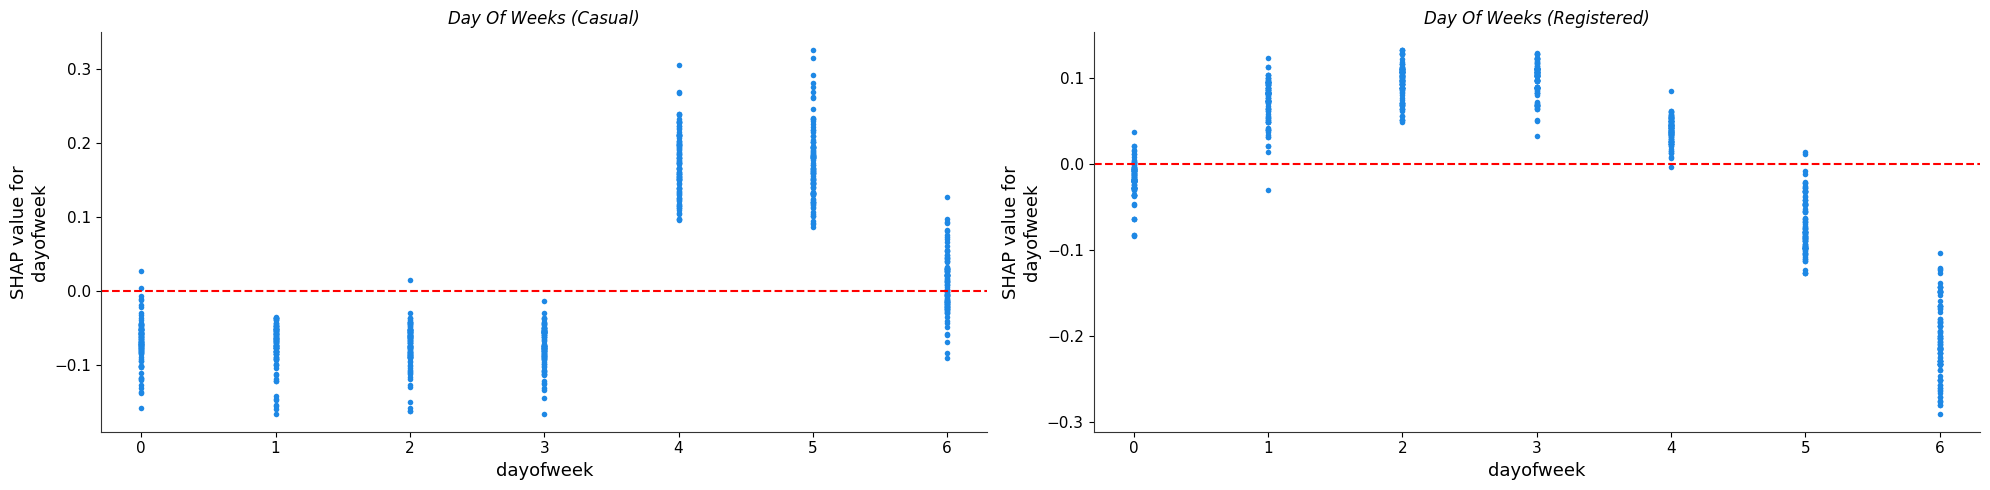

In [65]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 5), facecolor='white')  # Set the facecolor

# Set the background color of each subplot
for ax in axes:
    ax.set_facecolor('white')
    
# Plot the first shap.dependence_plot on the first subplot
shap.dependence_plot(
    ("dayofweek"),
    shap_values_casual,
    X_original,
    feature_names=NAMES,
    show=False,
    interaction_index=None,
    ax=axes[0]  # Use the first subplot
)

# Set the title and its text color for the first subplot
axes[0].set_title("Day Of Weeks (Casual)", color='black', style='italic')

# Plot the second shap.dependence_plot on the second subplot
shap.dependence_plot(
    ("dayofweek"),
    shap_values_registered,
    X_original,
    feature_names=NAMES,
    show=False,
    interaction_index=None,
    ax=axes[1]  # Use the second subplot
)

# Set the title and its text color for the second subplot
axes[1].set_title("Day Of Weeks (Registered)", color='black', style='italic')

# Set the axis labels (x-axis and y-axis) text color
for ax in axes:
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    
    # Set the color of the tick labels and tick marks
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')

# Add a horizontal line at y=0.0
axes[0].axhline(y=0.0, color='red', linestyle='--')
axes[1].axhline(y=0.0, color='red', linestyle='--')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


To analyze the differences and similarities between casual and registered customers, particularly in terms of their preferences on different types of days (working days vs. weekends), we used two XGBoostRegressor models with separate target variables: "casual" and "registered." The RMSE results of these models were RMSE (casual): 0.1744 and RMSE (registered): 0.1160, respectively.

For a more detailed understanding of the differences based on the type of day, we created two dependence plots focusing on the "dayofweek" feature, but as mentioned before now we have two dependence plots of two different targets casual and registerd.

Understanding the Dependence Plot (one feature):

- In the dependence plot, the x-axis represents the values of the "dayofweek" feature, ranging from 0 to 6, where 0 represents Monday and 6 represents Sunday.
- The y-axis represents the SHAP values, which indicate the impact of the "dayofweek" feature on the bike rental counts.
- The red line in the plot represents the baseline or reference value, which is typically set at 0. It serves as a reference point to compare the impact of each "dayofweek" value.

Here's what we observed from the dependence plots:

**Casual Customers:**
- **Weekends:**
    - Saturday: Casual customers show a significantly positive impact on bike rentals during weekends, particularly on Saturdays. This suggests that Saturdays attract a high number of casual customers.
    - Sunday: While Sundays still have a positive impact, it's somewhat lower than Saturdays.
- **Working Days:**
    - Friday: Fridays have a high positive impact on casual customers.
    - Monday to Thursday: Casual customers tend to have a negative impact on working days, meaning fewer rentals on these days compared to weekends.

**Registered Customers:**
- **Weekends:**
    - Saturday and Sunday: In contrast to casual customers, registered customers have a negative impact on weekends, both on Saturdays and Sundays. This indicates a lower preference for weekend rentals among registered customers.
- **Working Days:**
    - Tuesday to Friday: Registered customers show a positive impact on bike rentals during workingdays, particularly from Tuesday to Friday. This suggests that registered customers prefer renting bikes on these days.
    - Monday: Mondays show a somewhat negligible impact on registered customers. The SHAP values for Monday are very close to zero, indicating that it doesn't strongly influence their rental patterns.

Based on these findings, here are potential marketing strategies for different customer segments (Casual vs. Registered):

**Casual Customers:**
- **Weekends:**
    - Saturday: Capitalize on the positive impact of weekends, especially Saturdays, by offering weekend-specific promotions or discounts to attract more casual customers.
    - Sunday: Given the positive but lower impact of Sundays, work on strategies to boost Sunday rentals, such as special Sunday events or bike tours.
- **Working Days:**
    - Since workdays have a negative impact, focus on workday engagement strategies. Consider weekday-specific offers like "commuter packages" or flexible rental options tailored to short commutes.

**Registered Customers:**
- **Weekends:**
    - Acknowledge the negative impact of weekends. Instead of promoting weekend rentals, consider offering registered customers incentives for off-peak hours during weekends or flexible weekend packages.
- **Working Days:**
    - Leverage the positive impact of weekdays, particularly Tuesday to Friday, by introducing weekday loyalty programs or benefits for registered customers.
    - Assess the impact of Mondays further to determine whether marketing efforts are needed to boost rentals on this day. If necessary, develop targeted promotions or services for Mondays.

By tailoring marketing strategies to the specific preferences and behaviors of casual and registered customers, the bike rental company can maximize its customer base and overall profitability.

***
***
***

A-4. Based on the model and explanation results, explore the different seasons and atmospheric weather variables (e.g., temperature, feeling temperature, humidity, wind speed) in 2011 and 2012 that might affect the bike rental counts positively and/or negatively (if none, state that there would be no influence)?

What is your marketing strategy for the upcoming years or months if you are the CEO of this bike rental company?

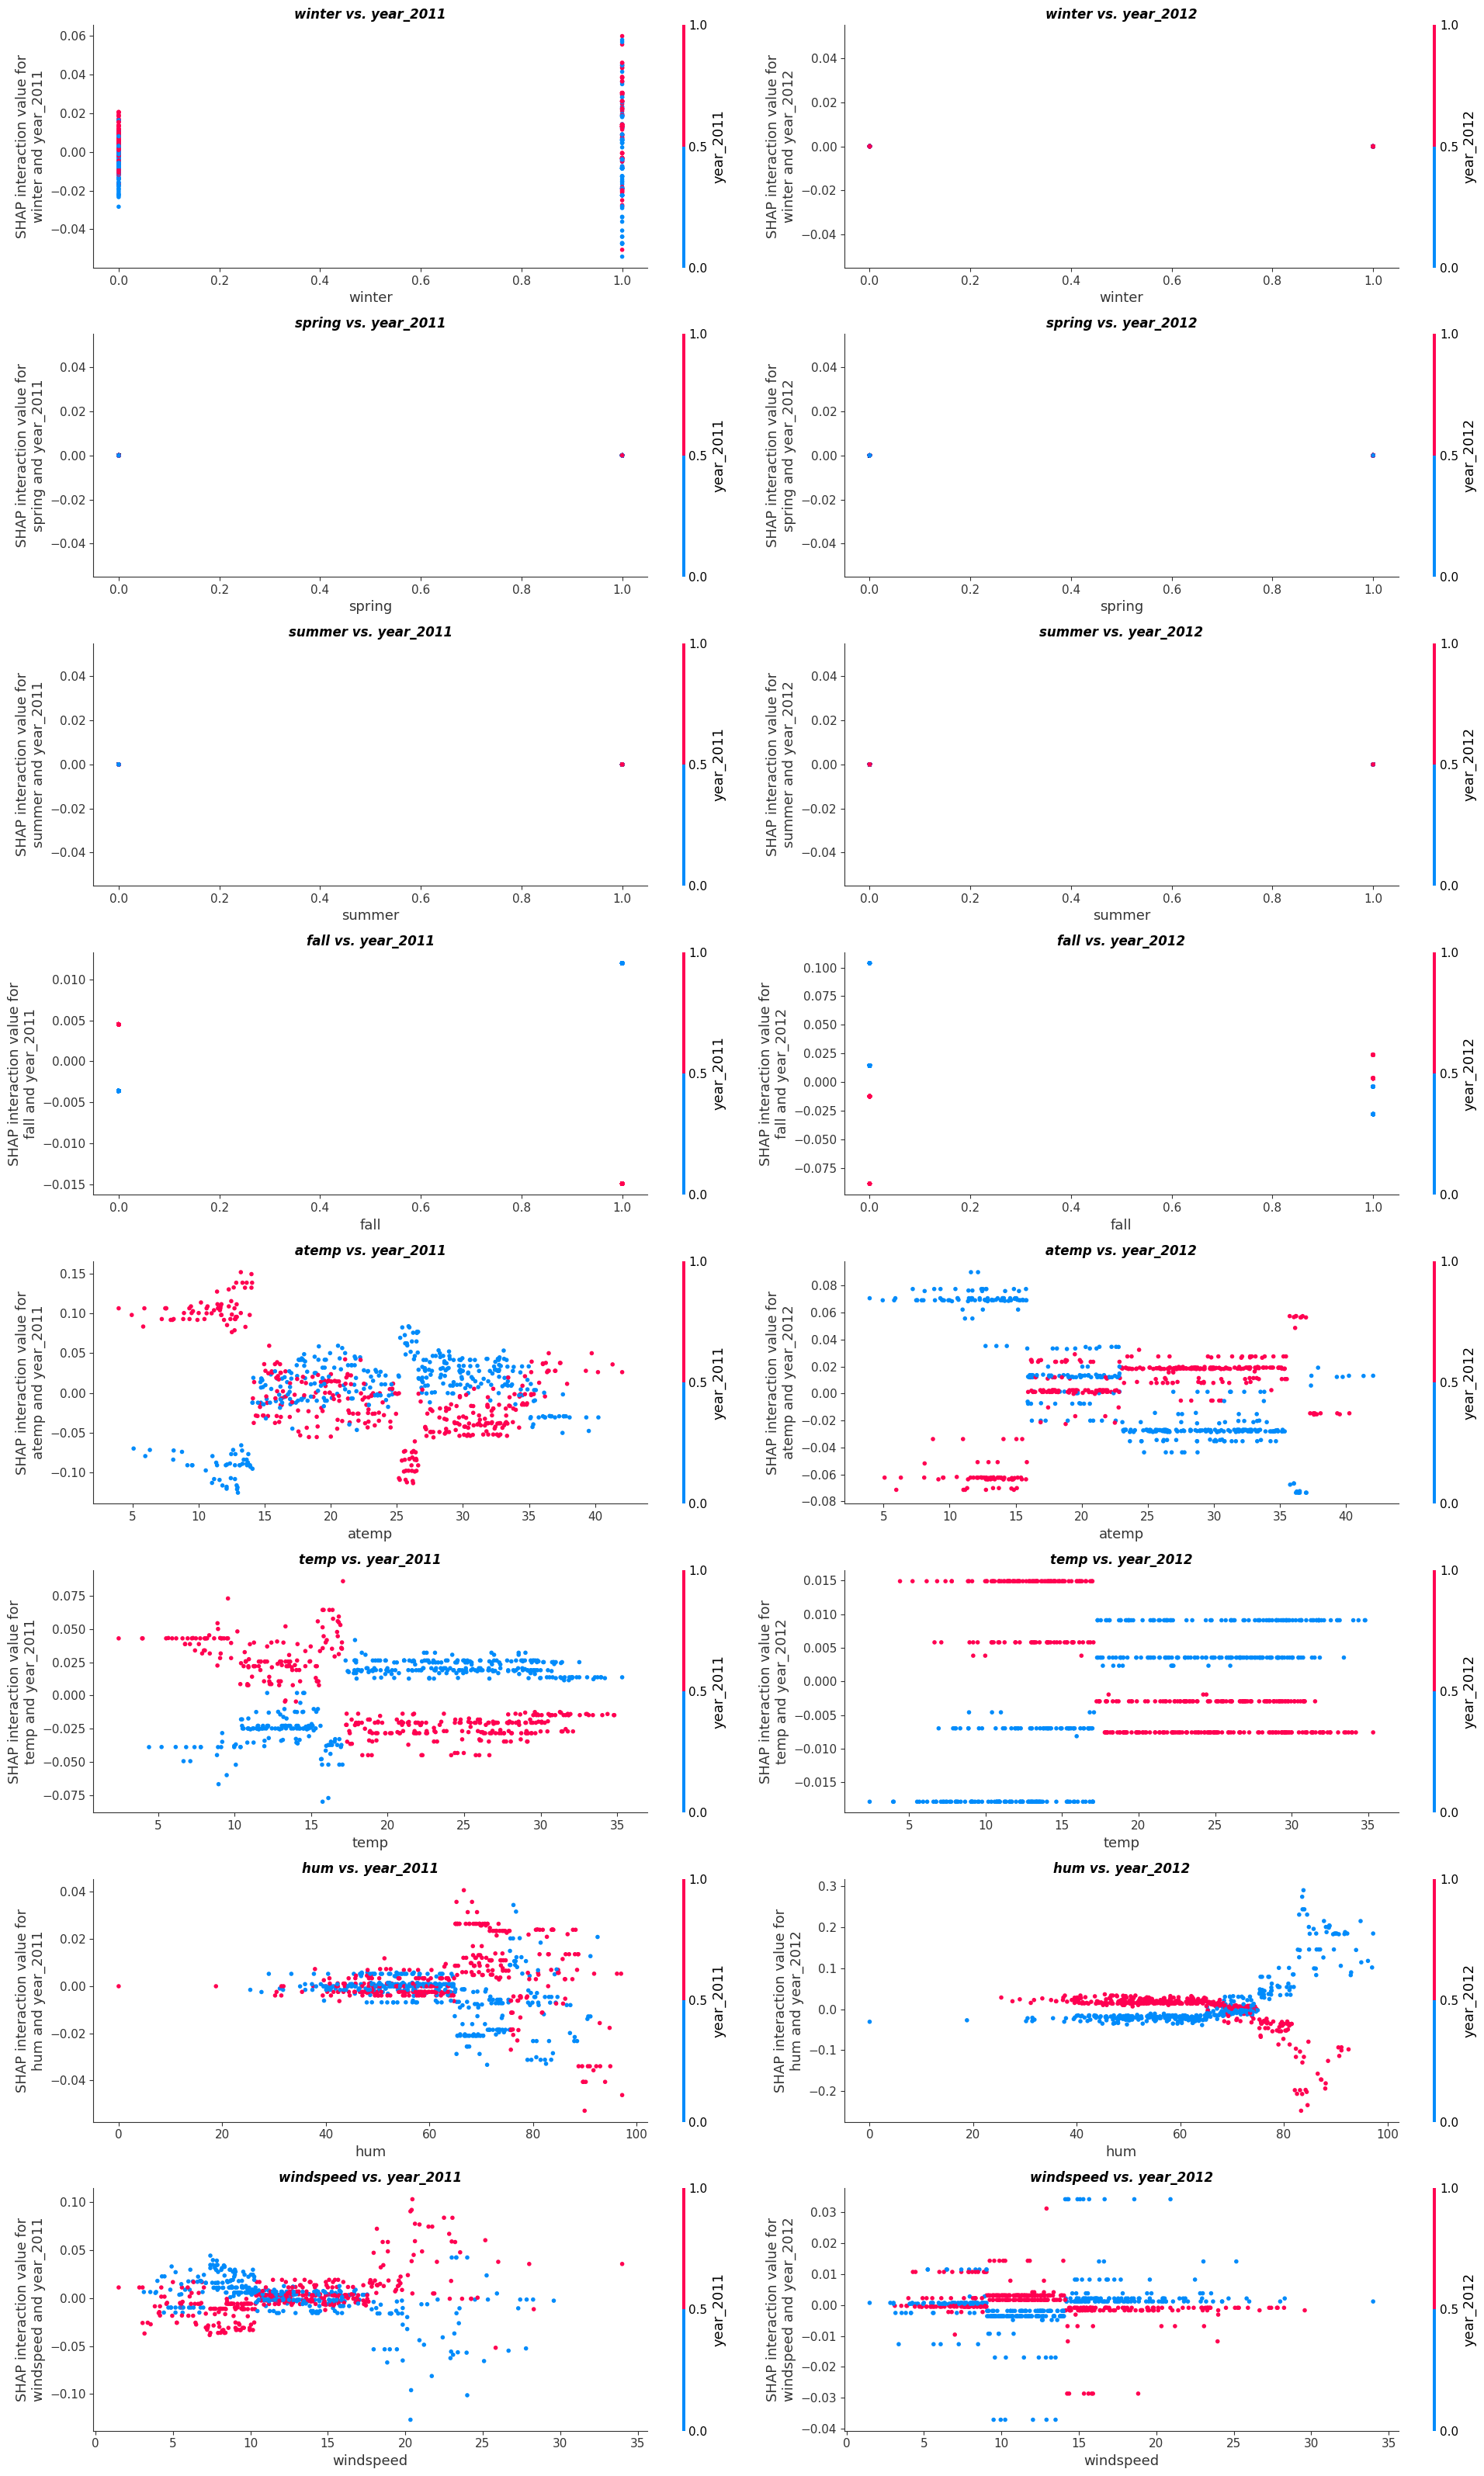

In [66]:
# Define the selected features
selected_features1 = ["winter", "spring", "summer", "fall", "atemp", "temp", "hum", "windspeed"]
selected_features2 = ["year_2011", "year_2012"]

# Create a grid of subplots for selected_features1 vs selected_features2
num_features1 = len(selected_features1)
num_features2 = len(selected_features2)

# Calculate SHAP interaction values
shap_interaction_values = explainer.shap_interaction_values(Xdf)

# Set up the subplot grid
fig, axes = plt.subplots(num_features1, num_features2, figsize=(20, 4 * num_features1))

# Loop through selected_features1 and selected_features2
for i in range(num_features1):
    for j in range(num_features2):
        feature1 = selected_features1[i]
        feature2 = selected_features2[j]
        feature_ = (feature1, feature2)

        # Create the dependence plot for the pair (feature1, feature2)
        shap.dependence_plot(
            feature_,
            shap_interaction_values, X_original,
            display_features=Xdf,
            ax=axes[i, j],
            show=False
        )
        
        # Set the title for the subplot
        axes[i, j].set_title(f"{feature1} vs. {feature2}", style="italic", weight='bold')

# Adjust spacing
plt.tight_layout()

# Show the combined plot
plt.show()

To analyze the potential influence of different seasons, atmospheric weather variables, and years on bike rental counts and formulate a marketing strategy, we utilized SHAP (SHapley Additive exPlanations) values and dependence plots. These insights provide valuable information from an explainable artificial intelligence (XAI) perspective.

Understanding dependence plots (two features):

These dependence plots illustrate the interaction between two features. In our context, the x-axis represents the feature of interest (winter, spring, summer, fall, temperature, feeling temperature, humidity, or windspeed) represented as ("**winter**", "**spring**", "**summer**", "**fall**", "**atemp**", "**temp**", "**hum**", "**windspeed**") respectively, and the y-axis displays the SHAP values, signifying their impact on bike rental counts. The color of data points provide the values of the second feature which is years represented as ("**year_2011**", "**year_2012**") in addition to further insights into the relationship.

**Seasonal Influence ("winter", "spring", "summer", "fall"):**

Our exploration of the seasons' influence found that interpreting the SHAP values for seasonal features was particularly challenging due to the categorical nature of the features. These features exhibited limited variations in SHAP values, making it difficult to draw definitive conclusions regarding their impact on bike rental counts in both 2011 and 2012. It's important to note that categorical vs. categorical feature interactions can be complex to interpret, and the results should be considered in this context.

**Atmospheric Weather Features:**

Analyzing atmospheric weather features (temperature, feeling temperature, humidity, windspeed) in relation to the years 2011 and 2012 revealed some noteworthy findings. The interpretation of these plots requires careful consideration of the SHAP values:

* **Feeling temperature vs Years 2011 and 2012:**
    - **atemp vs. year_2011:** In 2011, when feeling temperature (atemp) was low, it positively influenced bike rentals. However, the SHAP values remained quite low, suggesting that this impact might be minor.
    - **atemp vs. year_2012:** In contrast, for 2012, low feeling temperatures (atemp) negatively affected bike rentals, indicating that people were less inclined to rent bikes under such conditions. Again, the SHAP values were relatively small, underscoring the subtle nature of this influence.

- **Temperature vs Years 2011 and 2012:**
    - **temp vs. year_2011:** The dependence plot for temperature (temp) in 2011 indicated a positive impact when temperatures were low, but SHAP values were notably low, making it challenging to ascertain the significance of this effect.
    - **temp vs. year_2012:** The SHAP values for temperature (temp) in 2012 were exceptionally low, making it difficult to draw any meaningful conclusions regarding its impact.

* **Humidity vs Years 2011 and 2012:**
    - **hum vs. year_2011:** When humidity (hum) ranged between approximately 65 and 75 in 2011, it positively influenced bike rentals. However, the impact was modest, as reflected by the limited SHAP value range.
    - **hum vs. year_2012:** In 2012, high humidity negatively affected bike rentals. However, when humidity was high but the year was not 2012 (as shown by the blue observations), it had a positive impact. Moreover, this dependence plot has the most SHAP values range between -0.3 and 0.3.

- **Windspeed vs Years 2011 and 2012:**
    - **windspeed vs. year_2011:** Moderate windspeed in 2011 had a positive impact on bike rentals, but, once again, the SHAP values indicated a relatively weak influence.
    - **windspeed vs. year_2012:** The SHAP values for windspeed in 2012 were too low to discern any meaningful relationship.

Given the predominantly negligible impacts of these seasonal and atmospheric features on bike rentals, formulating a precise marketing strategy based on these factors may not yield significant results. Instead, a more comprehensive marketing strategy should focus on broader aspects, so I would design my marketing strategy for the upcoming years or months as follows:

- I would create personalized offers and recommendations for each customer group, based on their expected demand and impact on the bike rental counts. For example, I would offer discounts or rewards for customers who rent bikes on low-demand days or seasons. I would also increase prices or create special packages for customers who rent bikes on high-demand days or seasons.
- I would also monitor the weather forecast and adjust my pricing and promotion strategies accordingly. For example, I would lower prices or offer incentives for customers who rent bikes on cold or windy days etc. I would also raise prices or create scarcity for customers who rent bikes on sunny, pleasant, or calm days.
- I would also invest in improving the quality and comfort of my bikes and services, to reduce the negative effects of unfavorable weather conditions on customer satisfaction and retention. For example, I would provide more options for customers to adjust their bikes according to their preferences, such as seat height, handlebar angle, etc. I would also provide more amenities for customers, such as helmets, gloves, water bottles, etc.
- I would also leverage social media and online platforms to increase my brand awareness and customer loyalty. For example, I would create engaging content and campaigns that showcase the benefits and fun of biking, such as testimonials, videos, quizzes, etc. I would also encourage customers to share their experiences and feedback with us and with their friends and followers.

***
***
***

A-5. List the top 5 pairs of features that show high interactions and explain the interactions (SHAP interaction plot).

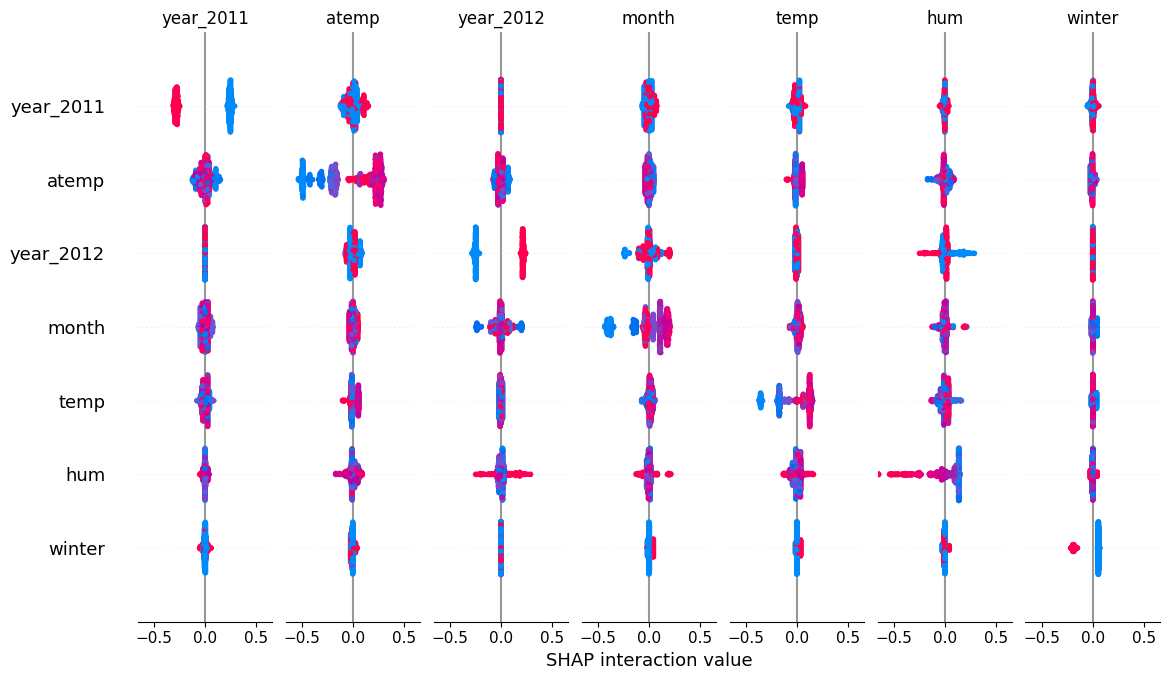

In [143]:
# Calculate SHAP interaction values
shap_interaction_values = explainer.shap_interaction_values(Xdf)

# Create a SHAP summary plot
shap.summary_plot(shap_interaction_values, Xdf, feature_names=NAMES, show=False)

# Get the current figure and axes
fig, axes = plt.gcf(), plt.gcf().get_axes()

# Set the background color for all columns
fig.patch.set_facecolor('white')
for ax in axes:
    ax.set_facecolor('white')

    # Set the title text color
    ax.set_title(ax.get_title(), color='black')

    # Set the x-label and y-label text color
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')

    # Set the color of the tick labels and tick marks
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')

# Show the plot
plt.show()


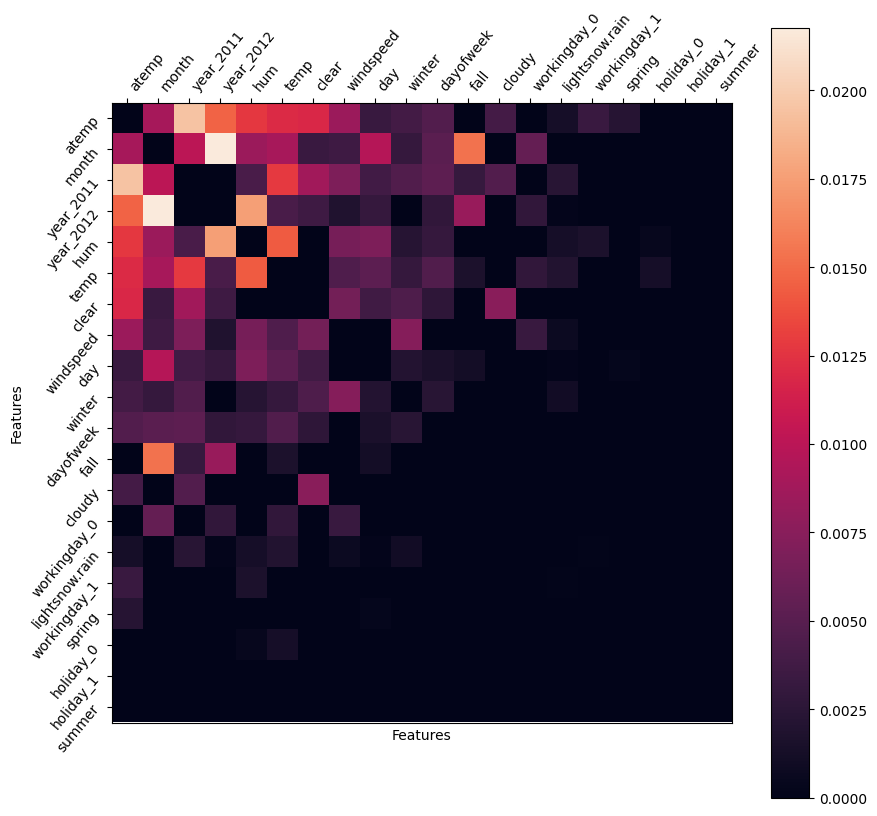

In [68]:
tmp = np.abs(shap_interaction_values).mean(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]

# Set the figure size
plt.figure(figsize=(10, 10), facecolor='white')

# Create the heatmap with a different colormap
heatmap = plt.imshow(tmp2, cmap='rocket')

# Set the background
plt.gca().set_facecolor('white')

# Set the y-labels and x-labels
plt.ylabel('Features', color='black')
plt.xlabel('Features', color='black')

# Set the y-ticks and x-ticks
plt.yticks(range(tmp2.shape[0]), Xdf.columns.values[inds], rotation=50.4, horizontalalignment="right", color='black')
plt.xticks(range(tmp2.shape[0]), Xdf.columns.values[inds], rotation=50.4, horizontalalignment="left", color='black')

# Show the colorbar
cbar = plt.colorbar(heatmap)
# Set the color of colorbar ticks, labels, and scale numbers
cbar.ax.tick_params(colors='black')

# Set the color of the heatmap ticks
plt.tick_params(axis='both', colors='black')

# Set the x-axis ticks on top
plt.gca().xaxis.tick_top()

# Show the plot
plt.show()

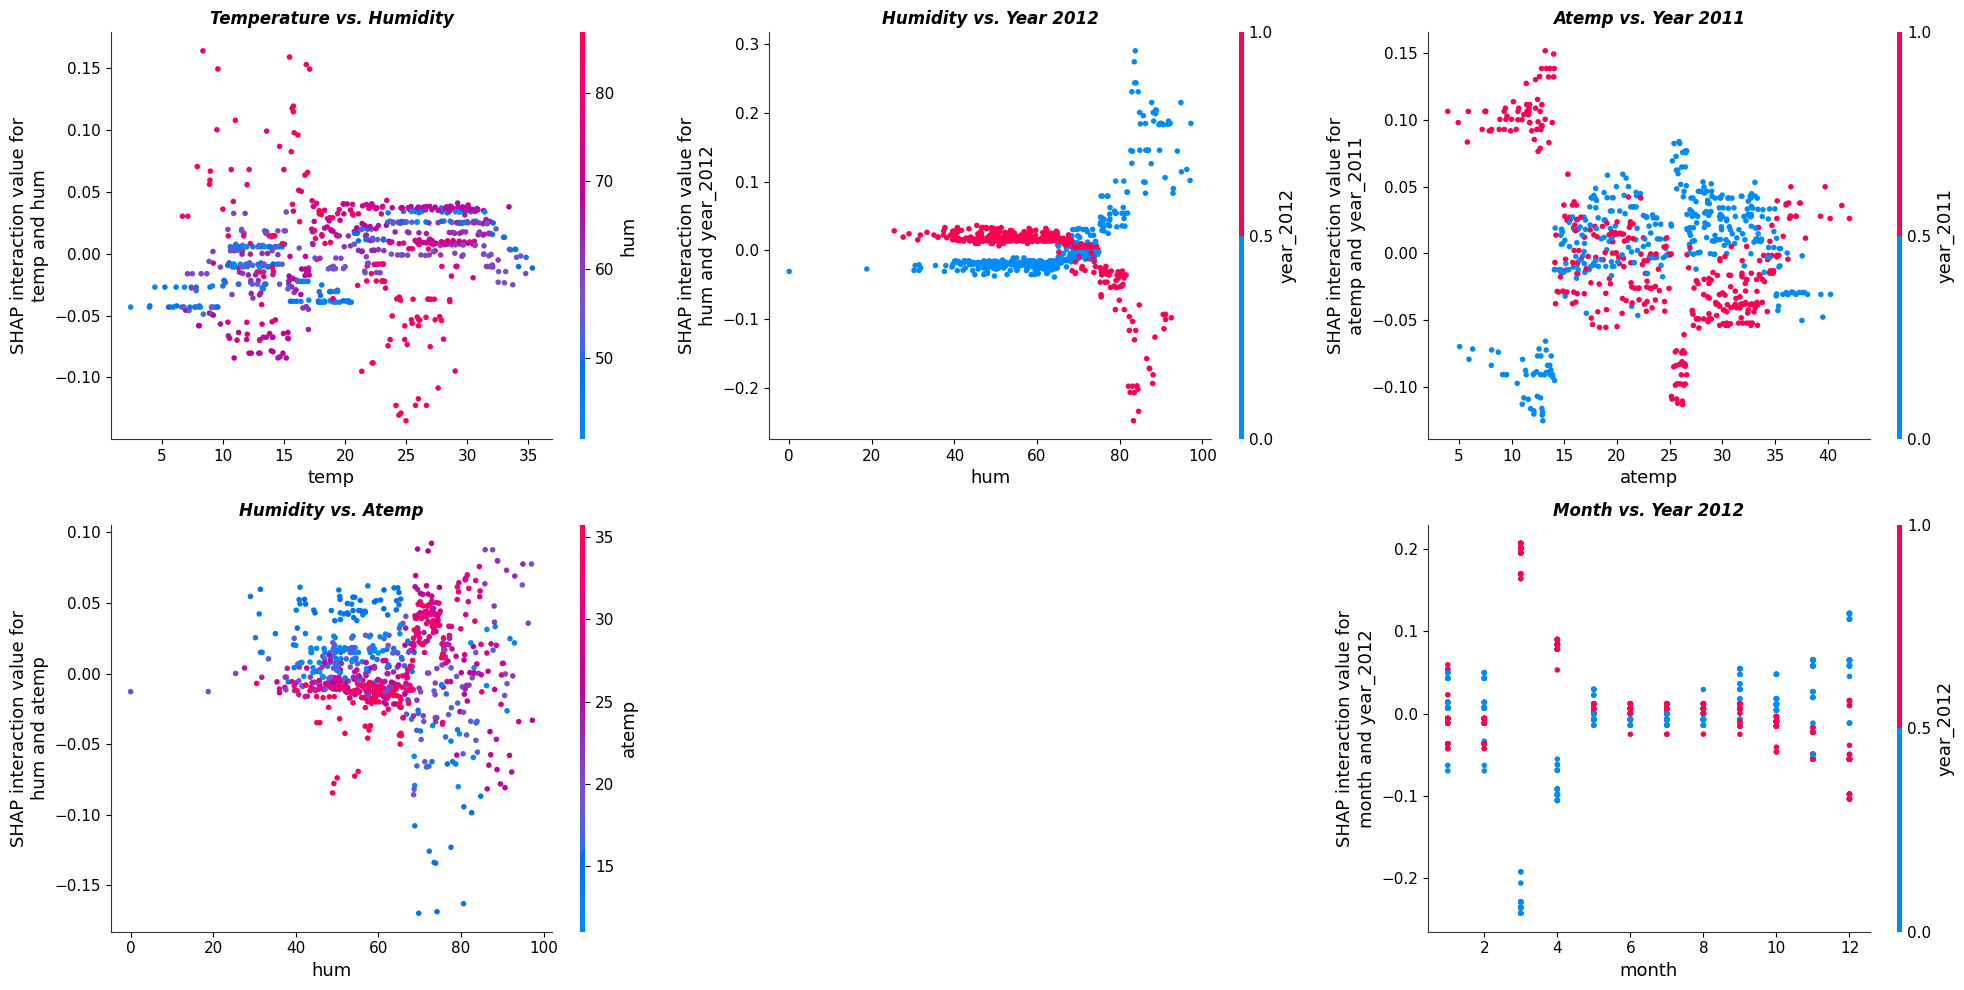

In [69]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 10), facecolor='white')

# Set the background color of each subplot
for ax_row in axes:
    for ax in ax_row:
        ax.set_facecolor('white')

# Plot the first shap.dependence_plot on the first subplot
shap.dependence_plot(
    ("temp", "hum"),
    shap_interaction_values, X_original,
    ax=axes[0, 0],  # Use the first subplot
    show=False
)
axes[0, 0].set_title("Temperature vs. Humidity", color='black', style='italic', weight='bold')
axes[0, 0].xaxis.label.set_color('black')  # Set x-label text color
axes[0, 0].yaxis.label.set_color('black')  # Set y-label text color
axes[0, 0].tick_params(axis='x', colors='black')  # Set tick label color
axes[0, 0].tick_params(axis='y', colors='black')  # Set tick label color

# Plot the second shap.dependence_plot on the second subplot
shap.dependence_plot(
    ("hum", "year_2012"),
    shap_interaction_values, X_original,
    ax=axes[0, 1],  # Use the second subplot
    show=False
)
axes[0, 1].set_title("Humidity vs. Year 2012", color='black', style='italic', weight='bold')
axes[0, 1].xaxis.label.set_color('black')
axes[0, 1].yaxis.label.set_color('black')
axes[0, 1].tick_params(axis='x', colors='black')
axes[0, 1].tick_params(axis='y', colors='black')

# Plot the third shap.dependence_plot on the third subplot
shap.dependence_plot(
    ("atemp", "year_2011"),
    shap_interaction_values, X_original,
    ax=axes[0, 2],  # Use the third subplot
    show=False
)
axes[0, 2].set_title("Atemp vs. Year 2011", color='black', style='italic', weight='bold')
axes[0, 2].xaxis.label.set_color('black')
axes[0, 2].yaxis.label.set_color('black')
axes[0, 2].tick_params(axis='x', colors='black')
axes[0, 2].tick_params(axis='y', colors='black')

# Plot the fourth shap.dependence_plot on the fourth subplot
shap.dependence_plot(
    ("hum", "atemp"),
    shap_interaction_values, X_original,
    ax=axes[1, 0],  # Use the fourth subplot
    show=False
)
axes[1, 0].set_title("Humidity vs. Atemp", color='black', style='italic', weight='bold')
axes[1, 0].xaxis.label.set_color('black')
axes[1, 0].yaxis.label.set_color('black')
axes[1, 0].tick_params(axis='x', colors='black')
axes[1, 0].tick_params(axis='y', colors='black')

# Plot the fifth shap.dependence_plot on the fifth subplot
shap.dependence_plot(
    ("month", "year_2012"),
    shap_interaction_values, X_original,
    ax=axes[1, 2],  # Use the fifth subplot
    show=False
)
axes[1, 2].set_title("Month vs. Year 2012", color='black', style='italic', weight='bold')
axes[1, 2].xaxis.label.set_color('black')
axes[1, 2].yaxis.label.set_color('black')
axes[1, 2].tick_params(axis='x', colors='black')
axes[1, 2].tick_params(axis='y', colors='black')

# Remove the empty subplot in the last column
fig.delaxes(axes[1, 1])

# Access the color bars and set their color
for ax in axes.flatten():
    if ax.collections:
        colorbar = ax.collections[0].colorbar
        colorbar.ax.yaxis.label.set_color('black')  # Set color bar label text color
        colorbar.ax.tick_params(axis='y', colors='black')  # Set color bar tick label color

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

To visualize the interactions between different features, we first plotted the SHAP interaction plot, which shows the SHAP values for each pair of features. The SHAP value measures how much the interaction of these two features contributes to the model output, either positively or negatively. The SHAP interaction plot is hard to read and analyze. Therefore, we plotted the heatmap, which quantifies the interaction features. The heatmap is a square grid with rows and columns labeled with feature names. The color scale ranges from 0.0000 to 0.0200, with shade orange or baige we can say being the highest value and black being the lowest value. The highest values in the heatmap indicate the pairs of features that have the most interaction.

Based on the heatmap, we were able to select the top 5 pairs of features from the SHAP interaction plot that show high interactions. These are:

- Temperature vs. Humidity
- Humidity vs. Year 2012
- Feeling temperature vs. Year 2011
- Humidity vs. Yeeling temperature
- Month vs. Year 2012

To analyze these pairs of features, we plotted the dependence plots for each pair. The dependence plots show how two features interact to affect the model output for each instance. The x-axis represents the first feature value and the y-axis represents the SHAP values. The color of each data point represents the second feature value. The dependence plots help us to understand the relationship between these pairs of features and how they influence the bike rental counts.

Here's what we observed from the dependence plots:

- **Temperature (temp) vs. humidity (hum):** 
    - When temperature is low and humidity is high, it has a positive impact on the bike rental counts. While when temperature is between 22°C and 30°C and humidity is high, it has a negative impact on the bike rental counts.

* **Humidity (hum) vs. year 2012 (year_2012):**
    - When humidity is high and year is 2012, it has a negative impact on the bike rental counts. While when humidity is high and year is not 2012, it has a positive impact on the bike rental counts.

- **Feeling temperature (atemp) vs. year 2011 (year_2011):**
    - When feeling temperature is low and year is 2011, it has a positive impact on the bike rental counts. When feeling temperature is moderate between 25°C and almost 30°C and year is 2011, it has a negative impact on the bike rental counts. When feeling temperature is low and year is not 2011, it has a negative impact on the bike rental counts.

* **Humidity (hum) vs. feeling temperature (atemp):**
    - When humidity is high and feeling temperature is low, it has a negative impact on the bike rental counts.
    
- **Month (month) vs. year 2012 (year_2012):**
    - When month is 3 (March) and year is 2012, it has a positive impact on the bike rental counts. When month is 3 (March) and year is not 2012, it has a negative impact on the bike rental.

***
***
***

A-6. Based on the model and explanation results, analyze how the time-related features, such as 'day,' 'month,' 'year_2011,' and 'year_2012,' impact bike rental counts positively and/or negatively.

As the CEO of this bike rental company, what strategies would you implement to optimize bike rentals considering these temporal trends?

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


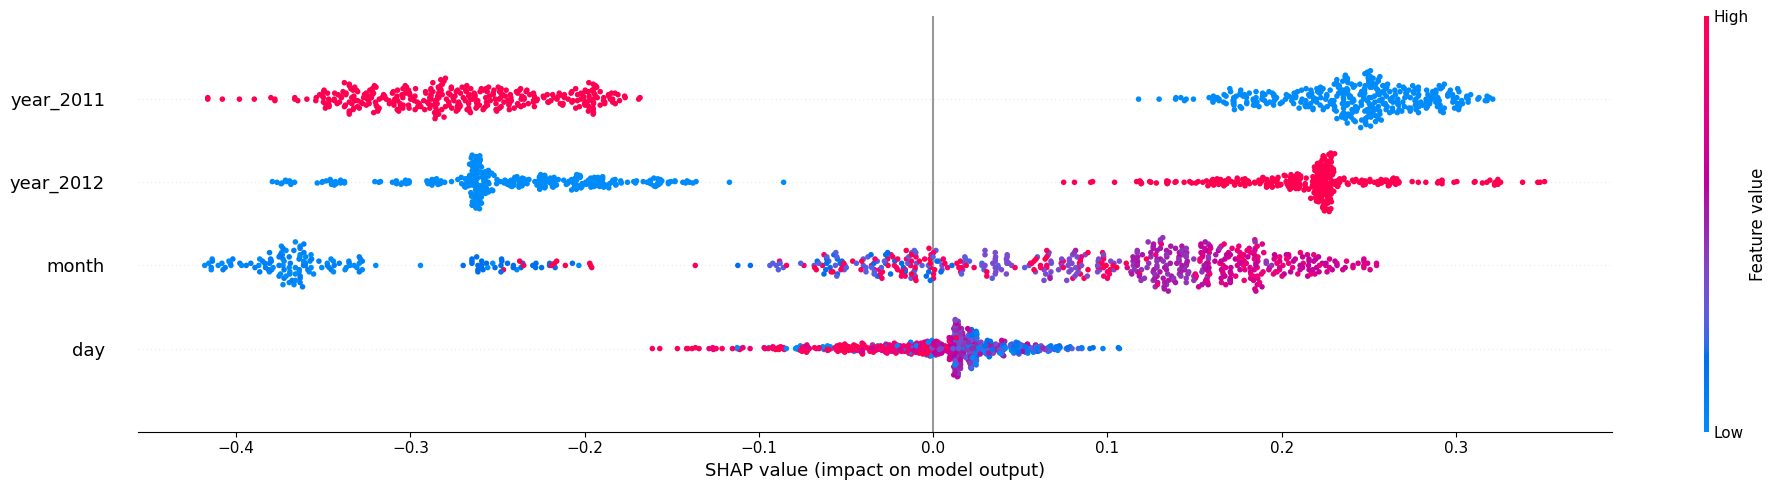

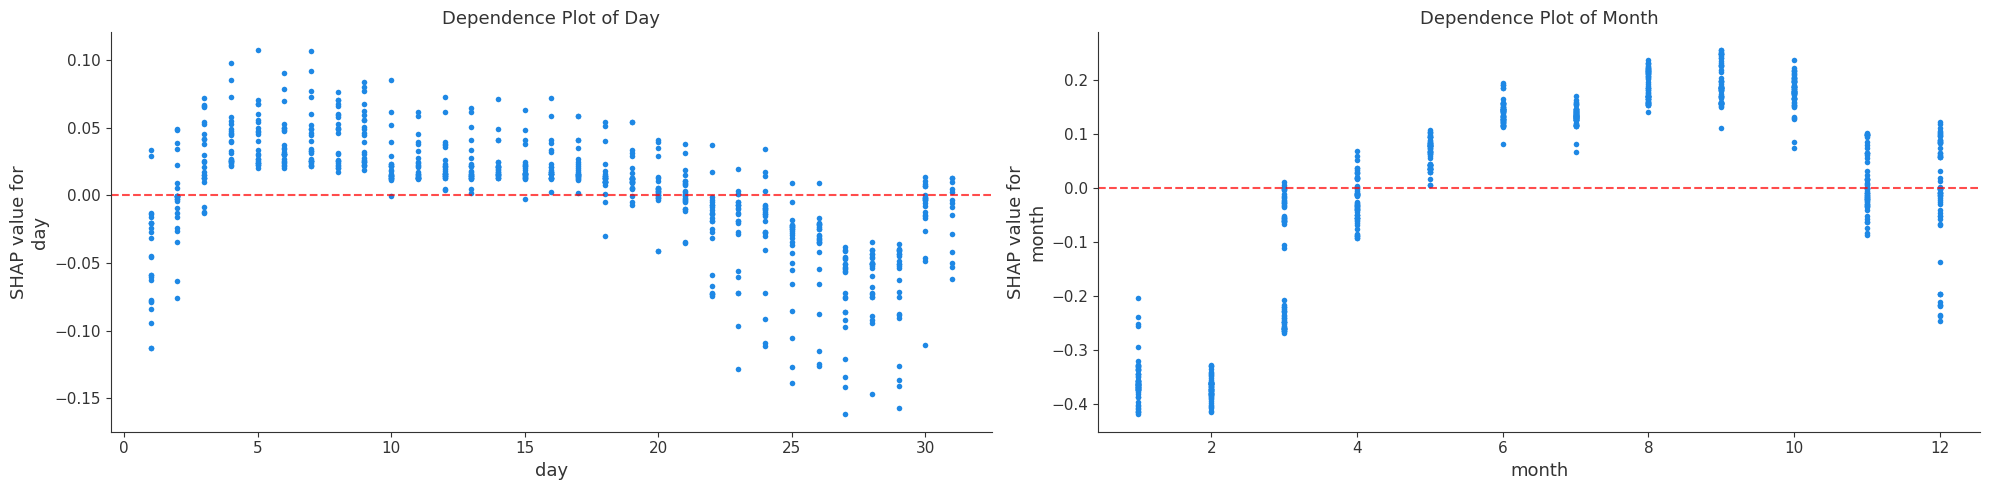

In [146]:
selected_features = ["day", "month", "year_2011", "year_2012"]

# Find the indices of the selected features in the original DataFrame
feature_indices = [Xdf.columns.get_loc(feature) for feature in selected_features]

# Sort the SHAP values and DataFrame based on the feature indices
selected_shap_values = shap_values[:, feature_indices]
selected_Xdf = Xdf[selected_features]

# Create a SHAP summary plot for the selected features
shap.summary_plot(selected_shap_values, selected_Xdf, show=False, axis_color="black", plot_size=(20,5))

# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Create the first dependence plot for "day"
shap.dependence_plot("day", shap_values, X_original, feature_names=NAMES, show=False, interaction_index=None, ax=axes[0], title="Dependence Plot of Day")

# Add a shaded line at y-axis zero
axes[0].axhline(y=0, color="red", linestyle="--", alpha=0.7)

# Create the second dependence plot for "month"
shap.dependence_plot("month", shap_values, X_original, feature_names=NAMES, show=False, interaction_index=None, ax=axes[1], title="Dependence Plot of Month")

# Add a shaded line at y-axis zero
axes[1].axhline(y=0, color="red", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust subplot spacing
plt.show()  # Display the combined plot


To illustrate how different features affect the bike rental counts, we used SHAP (SHapley Additive exPlanations) values and different type of plots to analyze . SHAP values measure how much each feature changes the model output, either positively or negatively. We use summary plots and dependence plots to visualize the SHAP values of the features. We also use these insights to suggest some marketing strategies for the bike rental company.

- Summary Plots provide a comprehensive view of how different features impact bike rental predictions:
    - On the vertical axis, we see the names of the features we're examining.
    - Along the horizontal axis, we find SHAP (SHapley Additive exPlanations) values, which indicate the direction and magnitude of impact.
    - Each dot on the plot represents a data point, with its position indicating whether it positively or negatively affects bike rental predictions.
    - Colors are used to distinguish different feature values.

* Dependence Plots, on the other hand, delve deeper into understanding the relationship between a specific feature and bike rental predictions:
    - The x-axis of these plots represents the feature we're interested in.
    - The y-axis displays SHAP values, showcasing how that feature influences predictions.
    - Each dot on the plot corresponds to a data point and tells us whether the feature positively or negatively affects bike rental predictions.
    - A dashed line at zero on the y-axis helps us identify when a feature has a neutral impact.

- **Year_2011 and Year_2012:**
    - The SHAP summary plot reveals distinct impacts of the years 2011 and 2012 features on bike rentals. Year_2011 is associated with a negative impact, suggesting a decline in rental activity during that year as shown by the red dots on the left side of the summary plo. Conversely, year_2012 exhibits a positive impact, indicating an increase in bike rentals as shown by the red dots on the right side of the summary plot.

To gain a more in-depth understanding of the impacts of the "day" and "month" features on bike rental counts, we employed Dependence Plots. These plots provided a detailed examination of how these temporal features influenced our predictions, allowing for a more nuanced analysis beyond what the summary plot could reveal.

* **Day:**
    - To further dissect the influence of the "day" feature, we turned to a dependence plot. It uncovered noteworthy trends: certain days, specifically the 27th, 28th, and 29th, are linked to a substantial decrease in bike rentals. Conversely, days 4th through 9th exhibit a significant positive impact, suggesting higher rental activity during this period.

- **Month:**
    - Similarly, the dependence plot for the "month" feature exposes temporal trends. January and February (months 1 and 2) exhibit a negative impact, indicating reduced bike rentals during these months. Conversely, months 6 through 10 (June, July, August, September, and October) are characterized by a positive influence, implying increased rental activity during this period.

As the CEO of the bike rental company, these insights into temporal trends offer valuable guidance for optimizing rental strategies:

- **Leverage Yearly Trends:** Given the positive impact of "Year_2012" and the negative influence of "Year_2011," focus on replicating the favorable conditions observed in 2012. Implement marketing campaigns and promotions that align with the factors contributing to increased rentals during that year.

- **Target Peak Days:** Capitalize on the knowledge that specific days, such as the 4th through 9th, drive higher rental activity. Tailor promotional offers, events, or discounts to attract customers during these periods.

- **Seasonal Promotions:** Recognize the seasonality in bike rentals, with months 6 through 10 being particularly favorable. Adjust pricing, marketing, and inventory strategies to cater to the higher demand during these months.

- **Off-Peak Strategies:** During the less favorable months (January and February) and on off-peak days (days 27th to 29th), consider implementing strategies such as promotions, discounts, maintenance, and inventory management to prepare for the busier months/days ahead.

By aligning rental strategies with these temporal trends, we can enhance overall business performance and maximize bike rentals.